## Libraries and Settings

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import datetime
from scipy import stats
import PyPDF2
import os
import re

# data viz
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
import seaborn as sns
import matplotlib.dates as mdates


#warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Viz Styling
plt.style.use('default')
rcParams['figure.figsize'] = (12,  6)
pd.set_option('display.max_columns',50)


## Import Data

In [2]:
trips = pd.read_excel('data/RAW-2019-Chevy-Bolt-Trip-Data.xlsx')

trips.head()

Vehicle Model          Start Date            End Date  Duration  \
0  2019 Chevrolet Bolt EV 2022-06-25 20:18:33 2022-06-25 20:25:43  00:07:10   
1  2019 Chevrolet Bolt EV 2022-07-16 20:43:47 2022-07-16 20:48:01  00:04:14   
2  2019 Chevrolet Bolt EV 2022-07-26 16:16:48 2022-07-26 16:23:35  00:06:47   
3  2019 Chevrolet Bolt EV 2022-05-18 20:33:28 2022-05-18 20:39:32  00:06:04   
4  2019 Chevrolet Bolt EV 2022-11-03 16:38:58 2022-11-03 16:43:54  00:04:56   

   Distance (mi)  Gasoline Consumed (gal)  Electricity Consumed (kWh)  \
0           1.59                      NaN                        0.01   
1           0.79                      NaN                        0.02   
2           1.91                      NaN                        0.06   
3           1.81                      NaN                        0.06   
4           1.60                      NaN                        0.06   

   Fuel Efficiency Equivalent (MPGeq)      mi/kWh  Starting SOC (%)  \
0                             5374.05  159.000000             76.08   
1                             1327.81   39.500000             83.92   
2                             1072.65   31.833333             70.98   
3                             1016.80   30.166667             38.04   
4                              900.91   26.666667             68.24   

   Ending SOC (%)  Ambient Temperature (F)  Smooth Acceleration (%)  \
0           76.08                      NaN                      NaN   
1           83.92                    78.80                      NaN   
2           70.58                    80.60                      NaN   
3           37.64                      NaN                      NaN   
4           67.84                    65.73                      NaN   

   Smooth Braking (%)  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN

In [3]:
# Finding null columns
np.sum(~trips.isnull())

Vehicle Model                         1201
Start Date                            1201
End Date                              1201
Duration                              1201
Distance (mi)                         1201
Gasoline Consumed (gal)                  0
Electricity Consumed (kWh)            1199
Fuel Efficiency Equivalent (MPGeq)    1110
mi/kWh                                1201
Starting SOC (%)                      1201
Ending SOC (%)                        1201
Ambient Temperature (F)               1011
Smooth Acceleration (%)                  0
Smooth Braking (%)                       0
dtype: int64

## Cleaning

In [4]:
# Removing Null Columns and irrelivant columns
trips.drop(labels = ['Vehicle Model', r'Gasoline Consumed (gal)'\
                     , r'Smooth Acceleration (%)', r'Smooth Braking (%)'], axis = 1, inplace = True)

In [5]:
# Removing 0.00 mile trips (i.e. I turned on the car for a minute, but didn't go anywhere)
trips = trips.loc[trips[r'Distance (mi)'] != 0 ,:]

# Removing negative electricity_consumed outliers.
trips = trips.loc[trips[r'Electricity Consumed (kWh)'] >= 0,:]


In [6]:
# converting SOC columns to decimal values (/100)
trips[r'Starting SOC (%)'] = trips[r'Starting SOC (%)']/100
trips[r'Ending SOC (%)'] = trips[r'Ending SOC (%)']/100

In [7]:
# Appending Columns to provide additional Analysis
# Projected Mile Range at Star and end of trip
# Using the formula (mi/kWh)*(SOC*battery size)
# battery size is 66kWh
battery_size = 66

trips['start_range'] = trips['mi/kWh']*(trips[r'Starting SOC (%)']*battery_size)
trips['end_range'] = trips['mi/kWh']*(trips[r'Ending SOC (%)']*battery_size)

In [8]:
trips.columns

Index(['Start Date', 'End Date', 'Duration', 'Distance (mi)',
       'Electricity Consumed (kWh)', 'Fuel Efficiency Equivalent (MPGeq)',
       'mi/kWh', 'Starting SOC (%)', 'Ending SOC (%)',
       'Ambient Temperature (F)', 'start_range', 'end_range'],
      dtype='object')

In [9]:
# Rename column names
trips = trips.rename(columns = {r'Start Date' : 'start_date',
           r'End Date' : 'end_date',
           r'Duration' : 'duration',
           r'Distance (mi)' : 'distance',
           r'Electricity Consumed (kWh)' : 'electricity_used',
           r'mi/kWh' : 'mikWh',
           r'Fuel Efficiency Equivalent (MPGeq)' : 'MPGe',
           r'Starting SOC (%)' : 'start_soc',
           r'Ending SOC (%)' : 'end_soc',
           r'Ambient Temperature (F)' : 'temp',
          }
         )

In [10]:
# trips['start_date'] = pd.to_datetime(trips['start_date']).dt.date
# trips['start_time'] = pd.to_datetime(trips['start_date']).dt.time
# trips['end_date'] = pd.to_datetime(trips['end_date']).dt.date
# trips['end_time'] = pd.to_datetime(trips['end_date']).dt.time

# trips

## Handling Missing Data

In [11]:
# Finding missing data
np.sum(~trips.isnull())

start_date          1092
end_date            1092
duration            1092
distance            1092
electricity_used    1092
MPGe                1092
mikWh               1092
start_soc           1092
end_soc             1092
temp                 924
start_range         1092
end_range           1092
dtype: int64

## Temperature NaN Values

There does not seem to be a pattern regarding the missing temperature data. 

There are 168 temperature data points missing, out of a total of 1092 data points. 

***13%*** of the temperature data points are missing. I have chosen to interpolate the missing data with a linear model. 

In [12]:
trips[trips.temp.isnull()].sort_values('start_date')#.describe()

start_date            end_date  duration  distance  \
961  2022-03-05 15:51:54 2022-03-05 15:59:33  00:07:39      1.62   
527  2022-03-09 17:18:45 2022-03-09 17:20:06  00:01:21      0.12   
528  2022-03-11 00:54:56 2022-03-11 00:55:33  00:00:37      0.04   
1047 2022-03-12 07:59:54 2022-03-12 08:01:07  00:01:13      0.01   
367  2022-03-19 16:05:20 2022-03-19 16:09:49  00:04:29      0.72   
...                  ...                 ...       ...       ...   
673  2022-11-19 15:25:29 2022-11-19 16:10:34  00:45:05     23.87   
5    2022-11-22 12:44:33 2022-11-22 12:49:55  00:05:22      1.60   
772  2022-11-25 08:21:56 2022-11-25 09:07:08  00:45:12     35.56   
740  2022-11-27 13:47:42 2022-11-27 13:49:15  00:01:33      0.24   
62   2022-11-27 18:24:23 2022-11-27 18:31:18  00:06:55      1.80   

      electricity_used    MPGe      mikWh  start_soc  end_soc  temp  \
961               0.69   79.34   2.347826     0.7647   0.7568   NaN   
527               0.03  136.13   4.000000     0.7058   0.7098   NaN   
528               0.01  148.70   4.000000     0.3020   0.3020   NaN   
1047              0.01   20.94   1.000000     0.4824   0.5333   NaN   
367               0.16  150.92   4.500000     0.5804   0.6000   NaN   
...                ...     ...        ...        ...      ...   ...   
673               6.63  121.36   3.600302     0.8118   0.6941   NaN   
5                 0.06  899.52  26.666667     0.9137   0.9137   NaN   
772              10.62  112.87   3.348399     0.5098   0.3255   NaN   
740               0.07  115.19   3.428571     0.9882   0.9882   NaN   
62                0.23  264.16   7.826087     0.9529   0.9490   NaN   

      start_range    end_range  
961    118.495252   117.271096  
527    186.331200   187.387200  
528     79.728000    79.728000  
1047    31.838400    35.197800  
367    172.378800   178.200000  
...           ...          ...  
673    192.899843   164.931979  
5     1608.112000  1608.112000  
772    112.662920    71.933661  
740    223.615543   223.615543  
62     492.193565   490.179130  

[168 rows x 12 columns]

In [13]:
# SORT by date then Interpolate Missing data points based on recent days
trips['temp'] = trips.sort_values('start_date').temp.interpolate(method = 'linear')

# new 'temp' column missing data points
np.sum(trips['temp'].isnull()) # 0

0

## Write clean data to .csv

In [14]:
trips.to_csv('data/CLEAN-2019-Chevy-Bolt-Trip-Data.csv', sep=',', encoding='utf-8')

## Data Summary

In [15]:
trips.describe()

distance  electricity_used         MPGe        mikWh    start_soc  \
count  1092.000000       1092.000000  1092.000000  1092.000000  1092.000000   
mean     15.934625          3.893306   152.240824     4.515056     0.726474   
std      23.537214          5.667625   184.777458     5.470657     0.161817   
min       0.010000          0.000000     0.000000     0.000000     0.000000   
25%       1.707500          0.390000   107.897500     3.201098     0.653925   
50%       5.290000          1.215000   132.995000     3.946428     0.749000   
75%      18.500000          5.230000   165.630000     4.913897     0.815600   
max     177.480000         42.320000  5374.050000   159.000000     1.000000   

           end_soc         temp  start_range    end_range  
count  1092.000000  1092.000000  1092.000000  1092.000000  
mean      0.663368    65.677898   216.435830   199.327548  
std       0.184336    15.691951   275.939166   277.616239  
min       0.000000    23.420000     0.000000     0.000000  
25%       0.567625    53.570000   139.373270   117.428309  
50%       0.690200    67.725000   189.269131   168.324154  
75%       0.764700    78.800000   250.614535   231.463846  
max       1.000000    99.540000  7983.835200  7983.835200

## Does Distance have an Effect on Effeciency?

In [16]:
# Quick Look at counts at different distances
short_trips = trips.loc[trips.distance<3.3]
med_trips = trips.loc[(trips.distance>=3.3) & (trips.distance<18)]
long_trips = trips.loc[trips.distance>=18]
print(short_trips.distance.count())
print(med_trips.distance.count())
print(long_trips.distance.count())

419
394
279


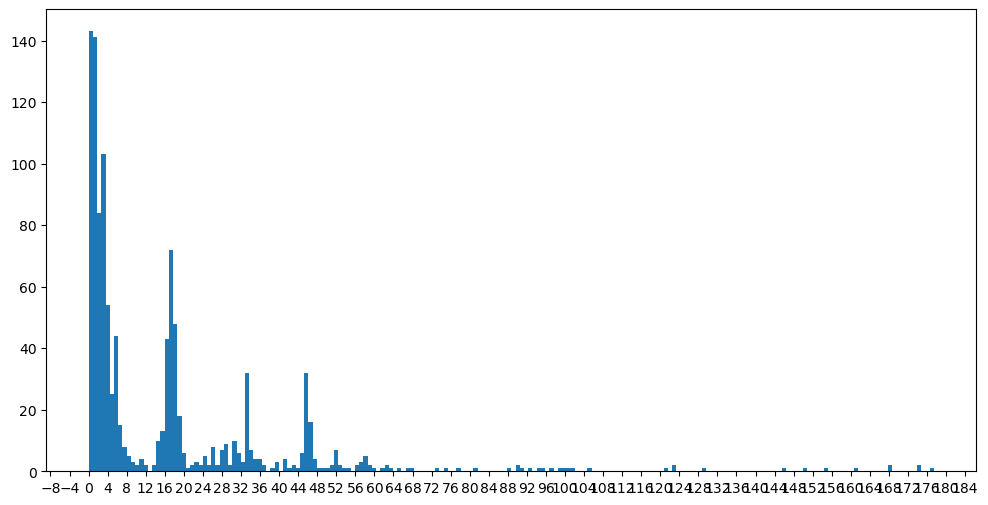

In [17]:
fig, ax = plt.subplots()
ax.hist(trips.distance, bins = 200)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4));

In [18]:
# creating quick function to append column with a category for how long the trip was
def distance_describer(x):
    if x['distance'] < 3.3:
        return 'Short Trip'
    if (x['distance'] >= 3.3) & (x['distance'] <18):
        return 'Medium Trip'
    if x['distance'] >= 18:
        return 'Long Trip'

In [19]:
#appending Column to Dataframe describing if the trip was short, medium, or long
trips['distance_desc'] = trips.apply(lambda x: distance_describer(x), axis = 1)
trips

start_date            end_date  duration  distance  \
0    2022-06-25 20:18:33 2022-06-25 20:25:43  00:07:10      1.59   
1    2022-07-16 20:43:47 2022-07-16 20:48:01  00:04:14      0.79   
2    2022-07-26 16:16:48 2022-07-26 16:23:35  00:06:47      1.91   
3    2022-05-18 20:33:28 2022-05-18 20:39:32  00:06:04      1.81   
4    2022-11-03 16:38:58 2022-11-03 16:43:54  00:04:56      1.60   
...                  ...                 ...       ...       ...   
1161 2022-06-30 14:31:39 2022-06-30 14:32:00  00:00:21      0.01   
1162 2022-07-03 08:20:48 2022-07-03 08:21:02  00:00:14      0.01   
1168 2022-07-29 13:43:33 2022-07-29 13:43:53  00:00:20      0.01   
1171 2022-08-15 12:30:25 2022-08-15 12:30:40  00:00:15      0.01   
1182 2022-10-10 10:37:11 2022-10-10 10:37:19  00:00:08      0.01   

      electricity_used     MPGe       mikWh  start_soc  end_soc       temp  \
0                 0.01  5374.05  159.000000     0.7608   0.7608  82.120000   
1                 0.02  1327.81   39.500000     0.8392   0.8392  78.800000   
2                 0.06  1072.65   31.833333     0.7098   0.7058  80.600000   
3                 0.06  1016.80   30.166667     0.3804   0.3764  61.855000   
4                 0.06   900.91   26.666667     0.6824   0.6784  65.730000   
...                ...      ...         ...        ...      ...        ...   
1161              0.00     0.00    0.000000     0.5882   0.5804  82.400000   
1162              0.00     0.00    0.000000     0.6470   0.6470  66.200000   
1168              0.00     0.00    0.000000     0.7568   0.7568  81.456667   
1171              0.00     0.00    0.000000     0.6196   0.6196  83.545000   
1182              0.00     0.00    0.000000     0.7568   0.7568  63.540000   

      start_range  end_range distance_desc  
0       7983.8352  7983.8352    Short Trip  
1       2187.7944  2187.7944    Short Trip  
2       1491.2898  1482.8858    Short Trip  
3        757.3764   749.4124    Short Trip  
4       1201.0240  1193.9840    Short Trip  
...           ...        ...           ...  
1161       0.0000     0.0000    Short Trip  
1162       0.0000     0.0000    Short Trip  
1168       0.0000     0.0000    Short Trip  
1171       0.0000     0.0000    Short Trip  
1182       0.0000     0.0000    Short Trip  

[1092 rows x 13 columns]

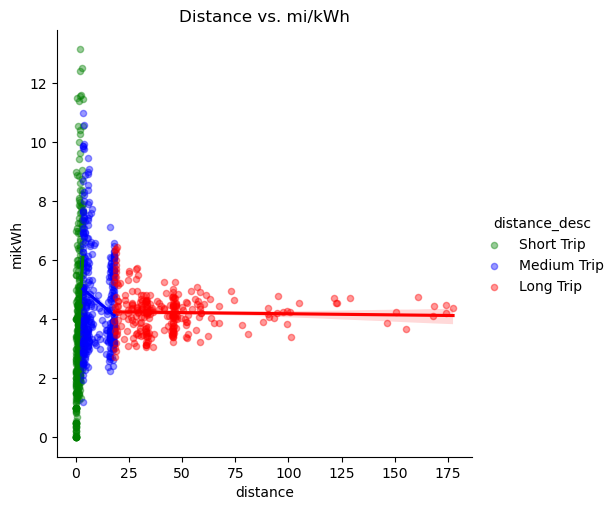

In [20]:
sns.lmplot(x='distance', y='mikWh', data=trips[trips.mikWh<15], hue='distance_desc',\
           palette = ['green','blue', 'red'], scatter_kws={"s": 20, "alpha":.4})
plt.title('Distance vs. mi/kWh');

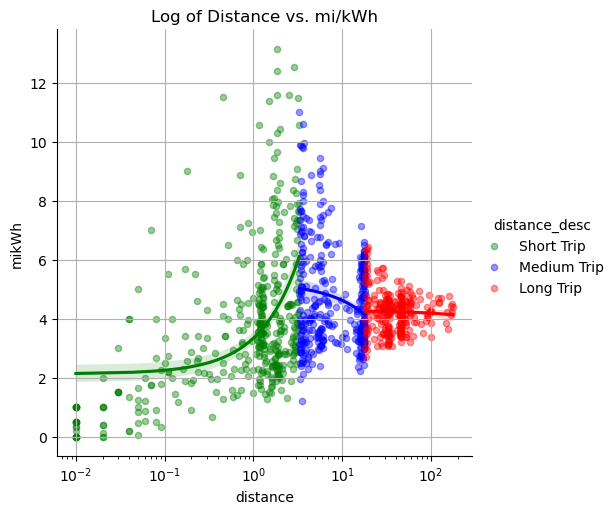

In [21]:
g = sns.lmplot(x='distance', y='mikWh', data=trips[trips.mikWh<15],\
               hue='distance_desc', palette = ['green','blue', 'red'], scatter_kws={"s": 20, "alpha":.4})
g.set(xscale="log") 
plt.title('Log of Distance vs. mi/kWh')
plt.grid(which='major');

## Does time of day have an Effect on Effeciency?

In [22]:
def time_describe(x):
    if (x >= 0) and (x < 6):
        return 'wee hours'
    elif (x >= 6) and (x < 12):
        return 'Morning'
    elif (x >= 12) and (x <= 18):
        return'Afternoon'
    elif (x >= 16) and (x < 24) :
        return 'Night'

In [78]:
trips['time_desc'] = trips.start_date.dt.hour.apply(time_describe)
trips

start_date            end_date  duration  distance  \
0    2022-06-25 20:18:33 2022-06-25 20:25:43  00:07:10      1.59   
1    2022-06-25 15:45:32 2022-06-25 15:50:47  00:05:15      0.76   
2    2022-06-25 16:00:32 2022-06-25 16:06:55  00:06:23      1.24   
3    2022-06-25 20:28:57 2022-06-25 20:35:15  00:06:18      1.44   
4    2022-06-25 10:42:28 2022-06-25 10:48:40  00:06:12      1.36   
5    2022-06-25 20:00:49 2022-06-25 20:06:28  00:05:39      1.83   
6    2022-06-25 15:52:50 2022-06-25 15:57:57  00:05:07      0.73   
7    2022-06-25 16:23:29 2022-06-25 16:23:56  00:00:27      0.01   
8    2022-06-25 18:43:56 2022-06-25 18:44:23  00:00:27      0.01   
9    2022-07-16 20:43:47 2022-07-16 20:48:01  00:04:14      0.79   
10   2022-07-16 18:38:16 2022-07-16 18:55:02  00:16:46      7.43   
11   2022-07-16 11:47:14 2022-07-16 12:04:56  00:17:42      7.43   
12   2022-07-16 19:09:22 2022-07-16 19:13:37  00:04:15      0.97   
13   2022-07-16 21:22:40 2022-07-16 21:32:25  00:09:45      1.83   
14   2022-07-16 10:26:18 2022-07-16 10:26:55  00:00:37      0.02   
15   2022-07-26 16:16:48 2022-07-26 16:23:35  00:06:47      1.91   
16   2022-07-26 11:18:03 2022-07-26 11:30:21  00:12:18      5.60   
17   2022-07-26 14:46:26 2022-07-26 14:51:56  00:05:30      1.22   
18   2022-07-26 13:44:30 2022-07-26 13:50:01  00:05:31      1.18   
19   2022-07-26 10:34:12 2022-07-26 10:46:56  00:12:44      5.82   
20   2022-07-26 10:54:39 2022-07-26 10:56:21  00:01:42      0.11   
21   2022-07-26 15:22:09 2022-07-26 15:28:54  00:06:45      1.87   
22   2022-05-18 20:33:28 2022-05-18 20:39:32  00:06:04      1.81   
23   2022-05-18 17:13:57 2022-05-18 17:23:54  00:09:57      3.40   
24   2022-05-18 19:41:59 2022-05-18 20:22:08  00:40:09     34.28   
25   2022-05-18 15:45:55 2022-05-18 16:37:16  00:51:21     46.37   
26   2022-05-18 08:06:53 2022-05-18 08:37:22  00:30:29     16.11   
27   2022-11-03 16:38:58 2022-11-03 16:43:54  00:04:56      1.60   
28   2022-11-03 16:49:02 2022-11-03 17:18:51  00:29:49     16.77   
29   2022-11-03 07:22:40 2022-11-03 07:55:37  00:32:57     17.82   
30   2022-11-22 12:44:33 2022-11-22 12:49:55  00:05:22      1.60   
31   2022-11-22 15:58:29 2022-11-22 16:32:36  00:34:07     17.71   
32   2022-11-22 18:06:40 2022-11-22 18:15:01  00:08:21      1.85   
33   2022-11-22 08:00:50 2022-11-22 08:27:50  00:27:00     17.77   
34   2022-11-22 12:55:54 2022-11-22 13:11:41  00:15:47      1.60   
35   2022-11-22 17:27:36 2022-11-22 17:34:59  00:07:23      1.57   
36   2022-03-20 11:50:07 2022-03-20 11:56:40  00:06:33      2.40   
37   2022-03-20 13:01:57 2022-03-20 13:11:53  00:09:56      3.61   
38   2022-03-20 11:23:08 2022-03-20 11:28:26  00:05:18      1.19   
39   2022-03-20 16:16:17 2022-03-20 17:13:55  00:57:38     34.20   
40   2022-03-20 20:36:39 2022-03-20 21:21:54  00:45:15     32.96   
41   2022-03-20 12:16:53 2022-03-20 12:27:38  00:10:45      3.55   
42   2022-03-20 15:55:31 2022-03-20 16:11:37  00:16:06      5.84   
43   2022-03-20 11:31:23 2022-03-20 11:40:06  00:08:43      1.61   
44   2022-03-20 20:09:52 2022-03-20 20:11:49  00:01:57      0.05   
45   2022-03-20 13:20:44 2022-03-20 13:21:05  00:00:21      0.01   
46   2022-07-21 11:11:44 2022-07-21 11:15:37  00:03:53      0.81   
47   2022-07-21 16:04:22 2022-07-21 16:49:54  00:45:32     25.05   
48   2022-07-21 21:25:14 2022-07-21 22:09:38  00:44:24     32.98   
49   2022-07-21 16:55:45 2022-07-21 17:10:36  00:14:51      6.94   
50   2022-07-21 10:45:23 2022-07-21 10:50:28  00:05:05      1.19   
51   2022-07-21 11:32:10 2022-07-21 11:40:41  00:08:31      1.88   
52   2022-07-17 20:35:08 2022-07-17 20:44:47  00:09:39      1.85   
53   2022-07-17 11:23:59 2022-07-17 11:33:38  00:09:39      3.62   
54   2022-07-17 10:04:33 2022-07-17 10:22:07  00:17:34      4.33   
55   2022-07-17 10:47:44 2022-07-17 10:51:45  00:04:01      0.60   
56   2022-07-17 20:23:17 2022-07-17 20:30:02  00:06:45      1.51   
57   2022-04-28 06:57:30 2022-04-28 06:59:52  00:02:22      1.28   
58

In [80]:
time_group = trips.groupby('time_desc')
time_group.mikWh.mean()

time_desc
Afternoon    4.558081
Morning      4.031660
Night        5.319164
wee hours    3.465224
Name: mikWh, dtype: float64

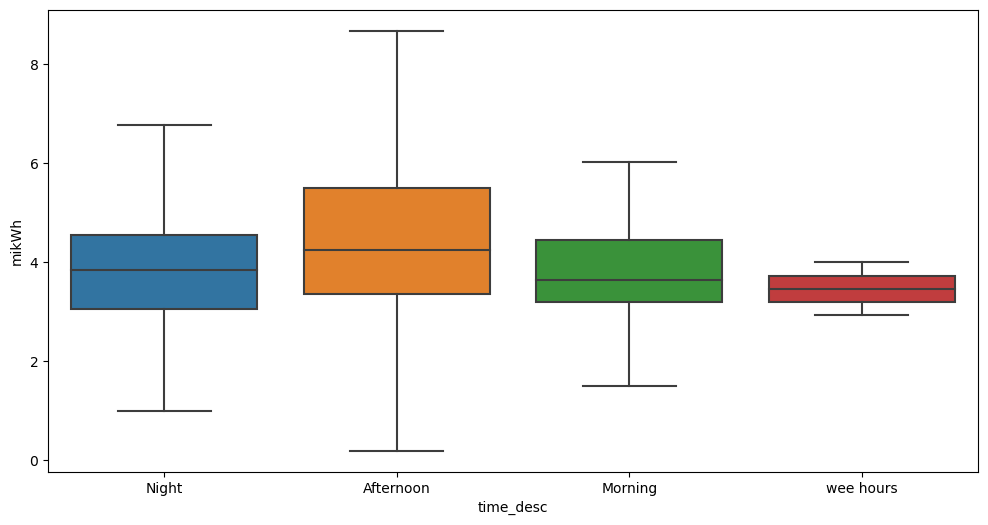

In [87]:
# fig, ax = plt.subplots()

y = trips.mikWh
x = trips.time_desc


sns.boxplot(x=x, y=y, data=trips, showfliers = False);

# Column Analysis

## Skewness and Kurtosis

<img src="images/skewness.png" width="500" align = "left"/>

<img src="images/kurtosis.jpg" width="400" align = "left"/>

In [34]:
# Skewness: asymmetry from the norm
print(f"Skewness: {trips[r'temp'].skew()}")
print(f"Kurtosis: {trips[r'temp'].kurt()}")

Skewness: -0.3164235937086513
Kurtosis: -0.7083586398754513


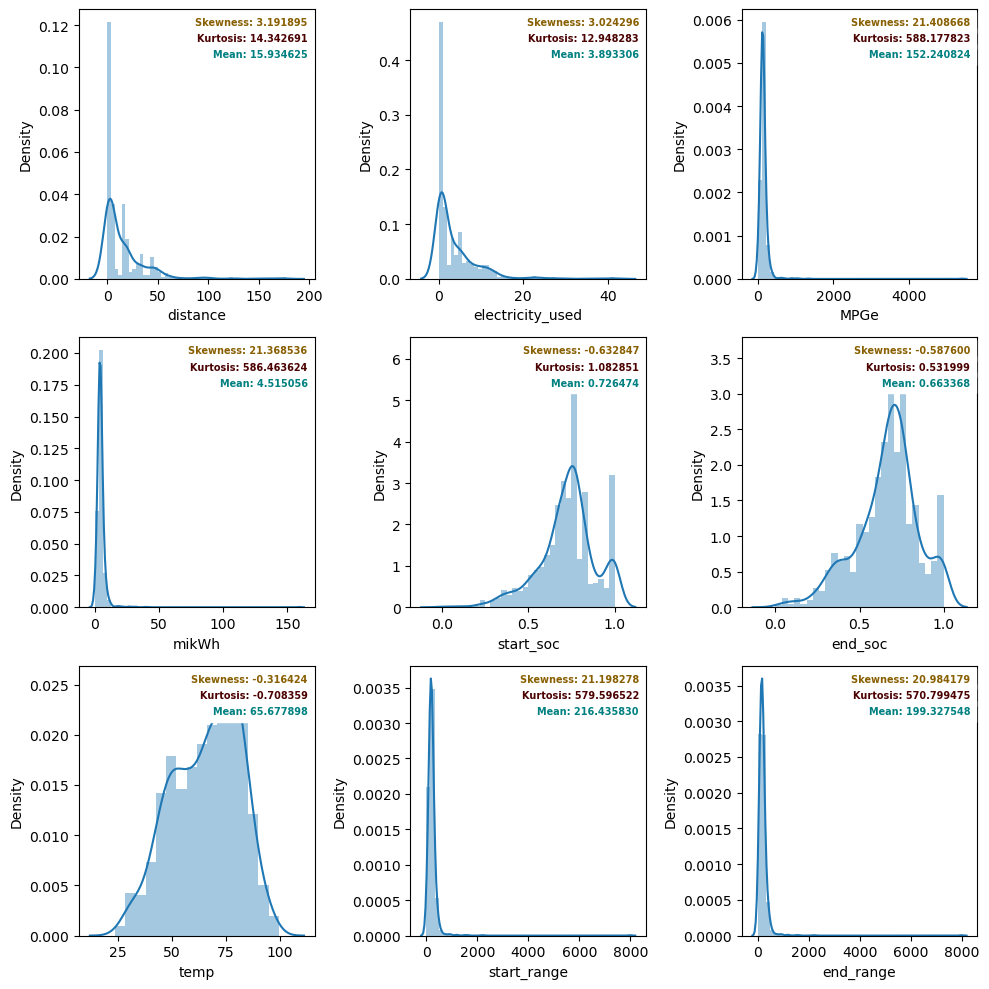

In [35]:
trips_facet = trips.iloc[:,3:12]

f, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=False)
sns.distplot(trips_facet.iloc[:,0], ax=axes[0,0])
sns.distplot(trips_facet.iloc[:,1], ax=axes[0,1])
sns.distplot(trips_facet.iloc[:,2], ax=axes[0,2])
sns.distplot(trips_facet.iloc[:,3], ax=axes[1,0])
sns.distplot(trips_facet.iloc[:,4], ax=axes[1,1])
sns.distplot(trips_facet.iloc[:,5], ax=axes[1,2])
sns.distplot(trips_facet.iloc[:,6], ax=axes[2,0])
sns.distplot(trips_facet.iloc[:,7], ax=axes[2,1])
sns.distplot(trips_facet.iloc[:,8], ax=axes[2,2])

for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % trips_facet.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % trips_facet.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
    ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % trips_facet.iloc[:,i].mean(),\
        fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='teal')
plt.tight_layout();



-------------------------------------

The data has a total of ***1092*** observations.

This data takes place in the <u>**temp range 23-100&deg;F**</u>

In [36]:
print(trips.temp.min())
print(trips.temp.max())

23.42
99.54


## distance 
Avg trip <u>**distance**</u> is 15.9 mi

In [37]:
trips.distance.mean()

15.934624542124526

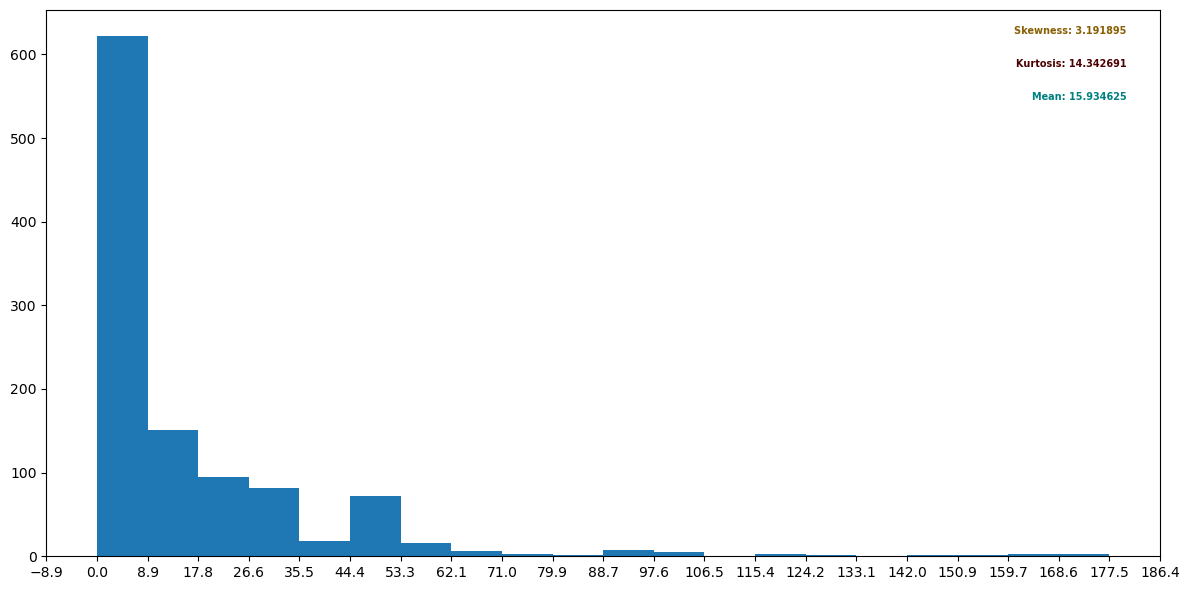

In [38]:
# distance

fig, ax = plt.subplots()
x = trips['distance']

plt.hist(x, bins = 20)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=23))
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout(); 

# fix x axis tickers BIN CUTS it's called. 

### Short trips < 3.3 mi
The distance series is very skewed  to the left (3.19) toward shorter trips. 

Because the data is skewed so much that way, I want to take a look at these shorter trips and see if they are properly distributed and verify the quality of the data.  

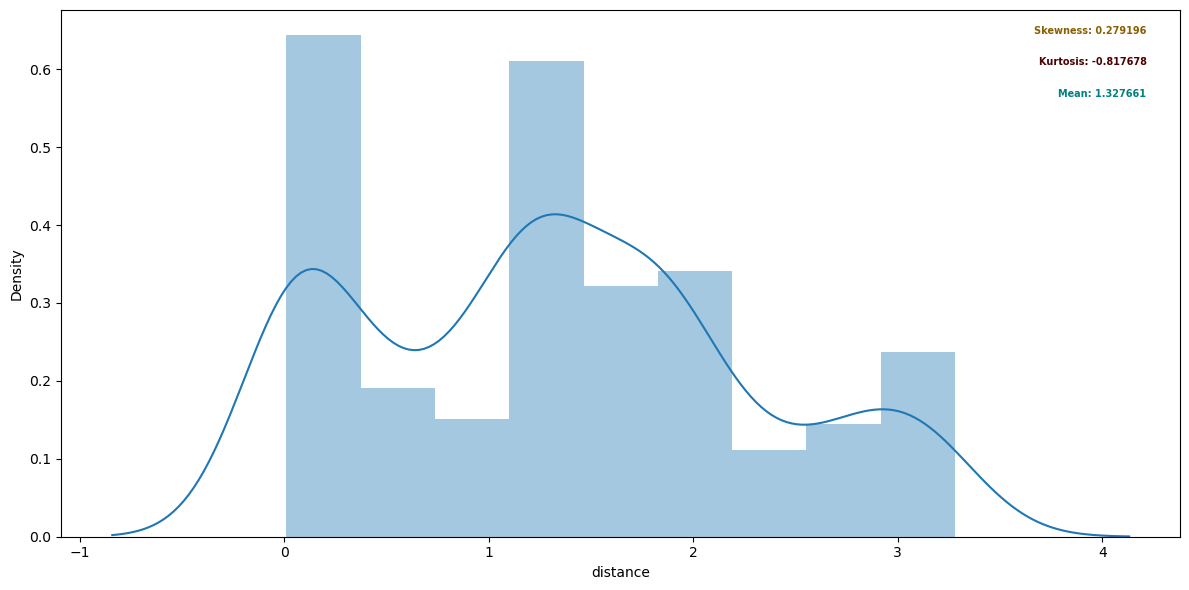

In [39]:
fig, ax = plt.subplots()
x = short_trips.distance
sns.distplot(x)


ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % x.skew(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % x.kurt(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='xkcd:dried blood')
ax.text(x=0.97, y=0.85, transform=ax.transAxes, s="Mean: %f" % x.mean(),\
    fontweight='demibold', fontsize=7, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='teal')
plt.tight_layout();


## electricity_used

An average trip uses <u>**3.89 kWh of energy**</u>.

This represents <u>**5.9%**</u> of the 66kWh Battery's capacity. 

This means if the battery is charged to 100%, on average a Chevy Bolt owner could get <u>**16 trips out of single charge.**</u> 

However, This is unrealistic because you shouldn't start a trip with less than 10%. In my dataset I started a trip with less than 10% <u>**2 times**</u> and ended a trip with less than 10% <u>**7 times**</u>. You also shouldn't really charge past 80% of the capcity. I did this <u>**305 times**</u>. ...Whoops.

So following all the best practices you are looking at an AVG of 11 trips of 15.5mi(3.88 kWh) each per responsible Charge. 

In [40]:
print(trips.electricity_used.mean()/66)
print(66//trips.electricity_used.mean())
print((66*.7)//trips.electricity_used.mean())
print(trips.loc[trips['start_soc']<.10,'distance'].count()) # amount of times I started a trip with less than 10%
print(trips.loc[trips['end_soc']<.10,'distance'].count()) # amount of times I ended a trip with less than 10%
print(trips.loc[trips['start_soc']>.80,'distance'].count()) # amount of times I started a trip with more than 80%

0.0589894827394828
16.0
11.0
2
7
305


11 trips, averaging 15 miles each sounds suffecient to me, but there are consumers that feel this isn't enough. And rightly fully so, considering that the US Federal Highway Administration shows that the average daily miles driven is ***36.9 miles*** * meaning that you could expect to get roughly two days out of the Chevy Bolt before you need to chargeup.

*https://www.fhwa.dot.gov/ohim/onh00/bar8.htm



In [41]:
13476/365
(66*.7)//36.9

1.0

However, the interesting thing that most consumer's do not understand, is that the biggest benefit to an electric vehicle is that you have a "Gas Station" in your own home. Every day you come home, you can plug in your vehicle and it's back to full by the next day.

This completely changes way drivers think about the chore of "re-fueling".I RARELY have to go out of my way to refuel this past year. 

Most drivers visit the gas station 2-4 amount of times a month.

I have visited a charging station 12 times this year to charge out of neccesity outside of my garage.  

Average starting <u>**State of Charge(SOC):**</u> is ***70%***, meaning I have followed good charging practices for the health of the battery and that the data is more realistic/representative towards reccomended best practices, and not idealistic numbers. 

In [42]:
trips.start_soc.mean()

0.7264735347985344

****Calculating MPGe****

In order to make any comparisions to gas vehicles we need some sort of conversion. The USA Environmental Protection Agency (EPA) has come up with a converstion to compare MPG to mi/kWh. It is called MPGe or "Miles per gallon equivalent"

Without getting too much in the weeds, the basis behind the conversion is that both burning gasoline and using electricity generates heat. so MPGe is essentially the heat equivalent of MPG. 

1 gallon of gas = 115,000 BTUs = 33.7kWh

<u> The avg MPGe for my trip data is 149.5 </u>

In [43]:
trips.MPGe.mean()

152.24082417582417

and an avg <u>trip effeciency: 4.49 mi/kWh</u>

In [44]:
trips.mikWh.mean()

4.515055595829802

# What do I do with Extreme mikWh values?
it's messing up the visuals and data?


In [45]:
trips.sort_values('MPGe', ascending = False)

start_date            end_date  duration  distance  \
0    2022-06-25 20:18:33 2022-06-25 20:25:43  00:07:10      1.59   
1    2022-07-16 20:43:47 2022-07-16 20:48:01  00:04:14      0.79   
2    2022-07-26 16:16:48 2022-07-26 16:23:35  00:06:47      1.91   
3    2022-05-18 20:33:28 2022-05-18 20:39:32  00:06:04      1.81   
4    2022-11-03 16:38:58 2022-11-03 16:43:54  00:04:56      1.60   
5    2022-11-22 12:44:33 2022-11-22 12:49:55  00:05:22      1.60   
6    2022-03-20 11:50:07 2022-03-20 11:56:40  00:06:33      2.40   
7    2022-07-21 11:11:44 2022-07-21 11:15:37  00:03:53      0.81   
8    2022-07-17 20:35:08 2022-07-17 20:44:47  00:09:39      1.85   
9    2022-04-28 06:57:30 2022-04-28 06:59:52  00:02:22      1.28   
10   2022-05-13 21:36:57 2022-05-13 21:46:16  00:09:19      2.57   
11   2022-11-12 15:23:02 2022-11-12 15:29:23  00:06:21      1.26   
12   2022-11-19 12:38:37 2022-11-19 12:45:15  00:06:38      1.84   
13   2022-10-09 11:00:19 2022-10-09 11:07:53  00:07:34      2.88   
14   2022-07-18 17:25:26 2022-07-18 17:32:27  00:07:01      1.86   
15   2022-06-09 15:19:40 2022-06-09 15:28:55  00:09:15      2.55   
16   2022-06-29 19:27:20 2022-06-29 19:33:55  00:06:35      1.85   
17   2022-09-10 11:55:48 2022-09-10 11:58:48  00:03:00      0.46   
18   2022-03-31 17:02:15 2022-03-31 17:13:20  00:11:05      3.21   
19   2022-03-05 16:01:15 2022-03-05 16:18:03  00:16:48      1.48   
20   2022-10-06 16:10:44 2022-10-06 16:27:53  00:17:09      3.30   
21   2022-09-25 16:40:15 2022-09-25 16:52:53  00:12:38      3.60   
22   2022-05-17 12:48:04 2022-05-17 13:01:30  00:13:26      3.27   
23   2022-07-28 08:42:50 2022-07-28 08:45:40  00:02:50      1.16   
24   2022-09-26 11:25:30 2022-09-26 11:34:17  00:08:47      1.98   
25   2022-08-02 18:05:34 2022-08-02 18:13:45  00:08:11      1.85   
26   2022-06-03 16:07:57 2022-06-03 16:13:20  00:05:23      1.50   
27   2022-04-05 17:38:01 2022-04-05 17:49:51  00:11:50      3.68   
29   2022-06-22 13:01:04 2022-06-22 13:13:24  00:12:20      3.36   
28   2022-10-31 13:47:08 2022-10-31 13:58:20  00:11:12      3.46   
30   2022-10-22 21:40:35 2022-10-22 21:48:48  00:08:13      3.53   
31   2022-05-10 15:52:50 2022-05-10 16:04:04  00:11:14      3.62   
32   2022-05-03 16:12:47 2022-05-03 16:20:31  00:07:44      1.83   
33   2022-08-05 11:09:16 2022-08-05 11:20:14  00:10:58      5.67   
34   2022-09-01 07:03:35 2022-09-01 07:08:50  00:05:15      1.70   
37   2022-04-12 19:36:09 2022-04-12 19:37:45  00:01:36      0.18   
35   2022-09-26 09:38:57 2022-09-26 09:53:40  00:14:43      6.10   
36   2022-04-13 19:12:02 2022-04-13 19:22:19  00:10:17      3.08   
38   2022-10-01 16:00:58 2022-10-01 16:12:06  00:11:08      5.67   
39   2022-10-10 13:31:30 2022-10-10 13:46:19  00:14:49      5.61   
40   2022-06-24 16:02:04 2022-06-24 16:12:45  00:10:41      4.44   
42   2022-05-11 08:20:50 2022-05-11 08:27:40  00:06:50      1.68   
41   2022-05-07 13:44:25 2022-05-07 13:49:08  00:04:43      0.71   
43   2022-04-23 21:12:12 2022-04-23 21:22:37  00:10:25      2.97   
44   2022-10-02 16:52:53 2022-10-02 17:02:17  00:09:24      3.47   
45   2022-09-15 16:09:52 2022-09-15 16:17:12  00:07:20      1.98   
46   2022-04-08 16:17:05 2022-04-08 16:34:53  00:17:48      5.55   
47   2022-08-17 14:00:07 2022-08-17 14:12:59  00:12:52      5.69   
49   2022-09-14 16:19:13 2022-09-14 16:26:12  00:06:59      2.76   
48   2022-06-23 17:56:21 2022-06-23 18:04:09  00:07:48      1.84   
50   2022-04-02 14:44:47 2022-04-02 14:55:59  00:11:12      3.65   
51   2022-08-03 14:19:46 2022-08-03 14:28:26  00:08:40      3.05   
52   2022-03-20 13:01:57 2022-03-20 13:11:53  00:09:56      3.61   
53   2022-09-08 18:42:51 2022-09-08 18:48:30  00:05:39      1.70   
54   2022-09-03 15:16:18 2022-09-03 15:23:45  00:07:27      1.61   
55   2022-09-30 18:00:06 2022-09-30 18:11:07  00:11:01      3.60   
56   2022-10-05 15:28:48 2022-10-05 15:47:34  00:18:46      6.14   
57   2022-08-06 11:14:25 2022-08-06 11:23:51  00:09:26      1.91   
58

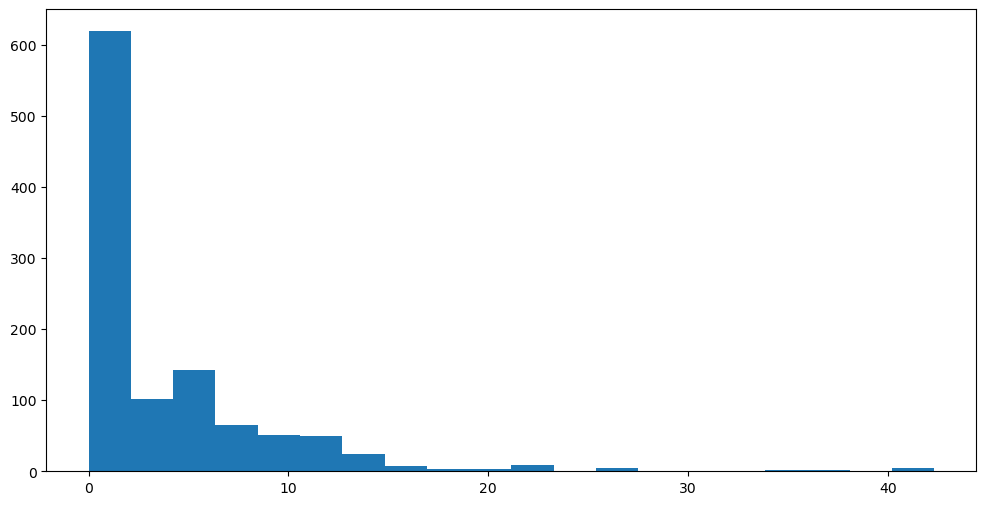

In [46]:
# electricity_used
x = trips['start_date']
y = trips['electricity_used']
plt.hist(y, bins = 20);


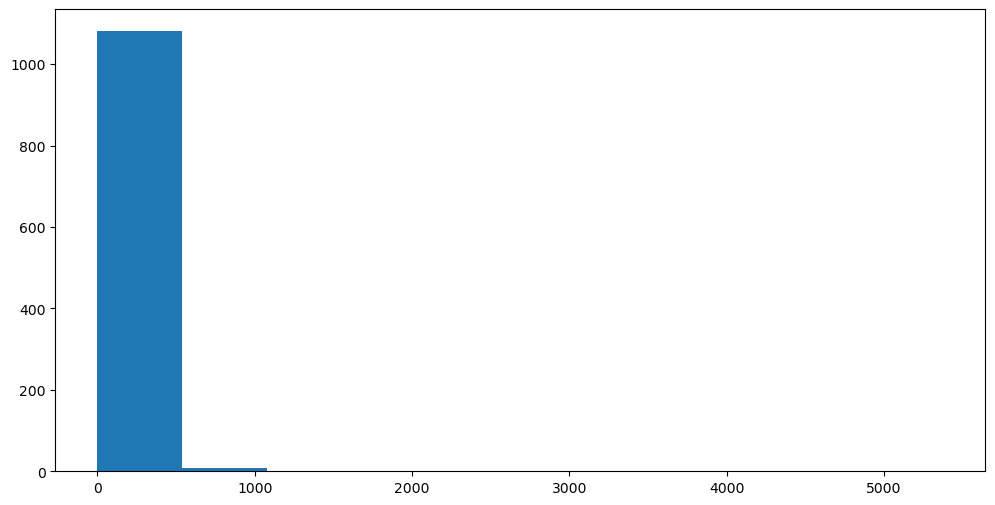

In [47]:
# MPGe
y = trips['MPGe']

plt.hist(y,bins=10);

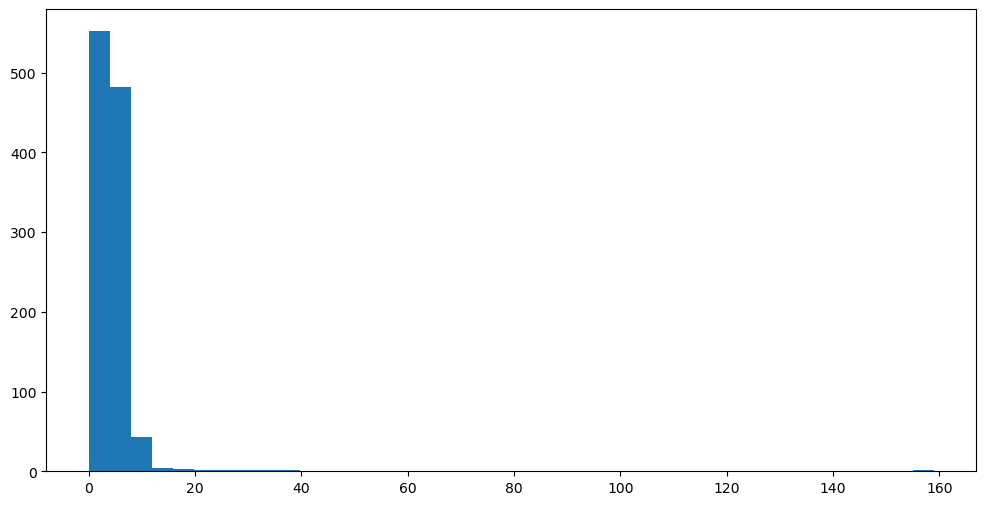

In [48]:
# mikWh
y = trips['mikWh']
plt.hist(y,bins=40);

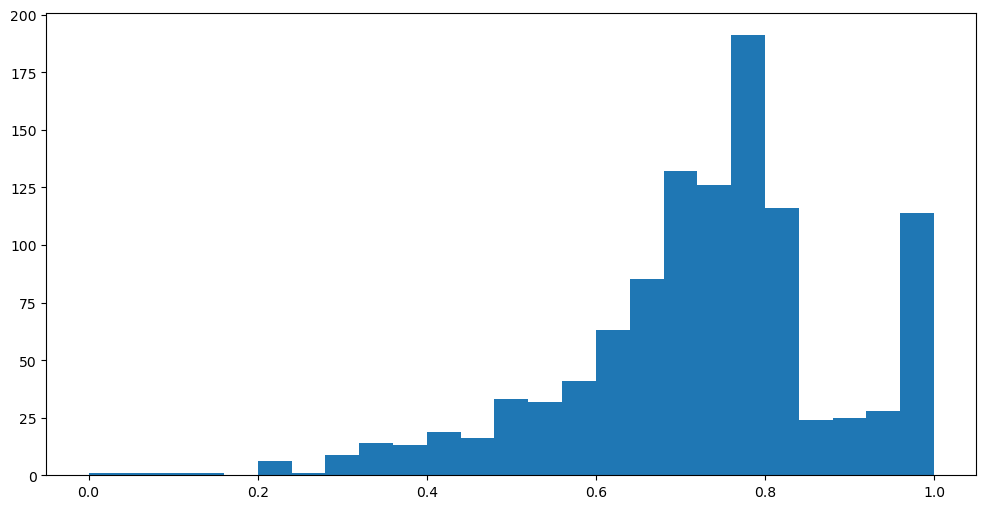

In [49]:
# start_soc
y = trips['start_soc']
plt.hist(y,bins=25);

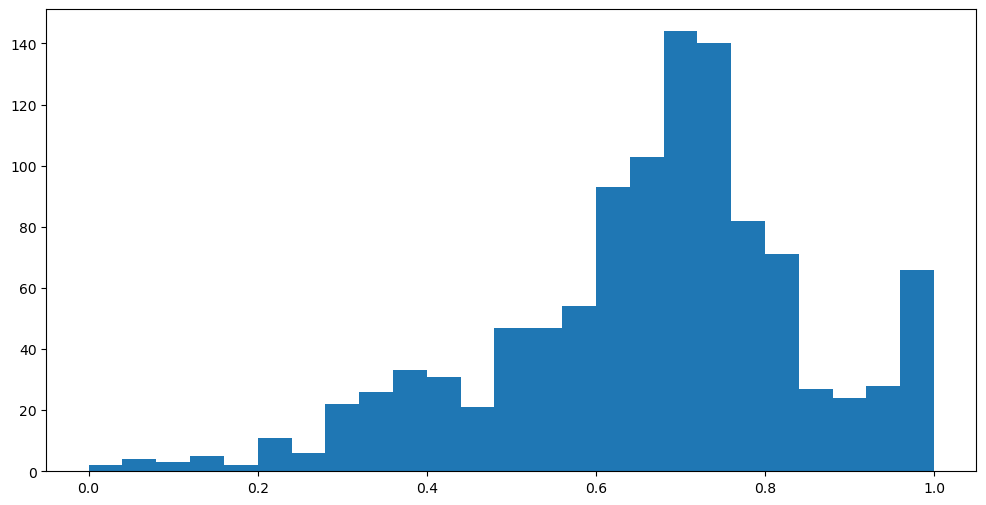

In [50]:
# end_soc
y = trips['end_soc']
plt.hist(y,bins=25);

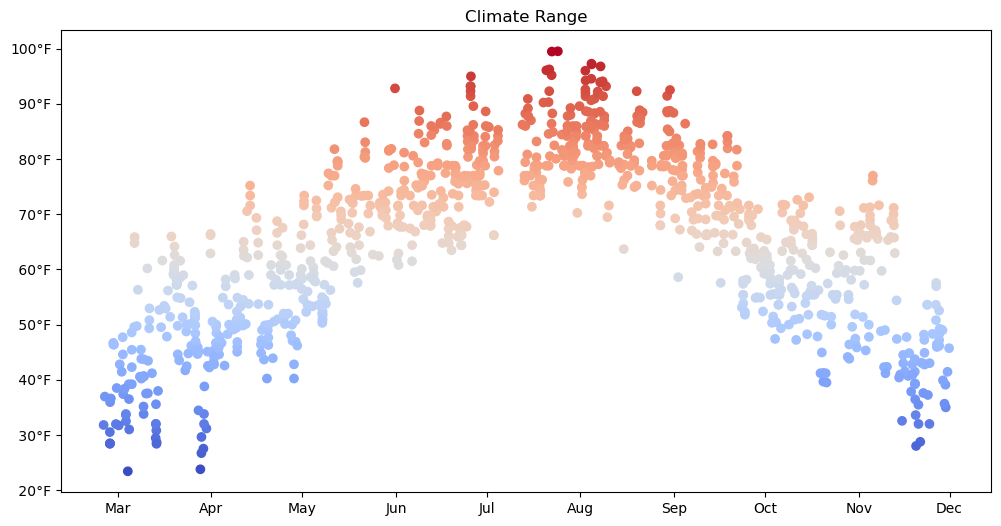

In [51]:
my_fmt = mdates.DateFormatter('%m')

def fahr_format(x, pos):
    """The two arguments are the value and tick position."""
    return '{:3.0f}°F'.format(x)


x = trips['start_date']
y = trips['temp']

fig, ax = plt.subplots()
ax.scatter(x,y,c = trips.loc[:,'temp'], cmap = 'coolwarm')

ax.set_title('Climate Range')

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.yaxis.set_major_formatter(fahr_format)
# ax.ticklabel_format(axis='y',) FormatStrFormatter('%°f')

# ax.set_yticklabels(['{:,\d}'.format(x) for x in ax])


Text(0.5, 1.0, 'Driving Conditions')

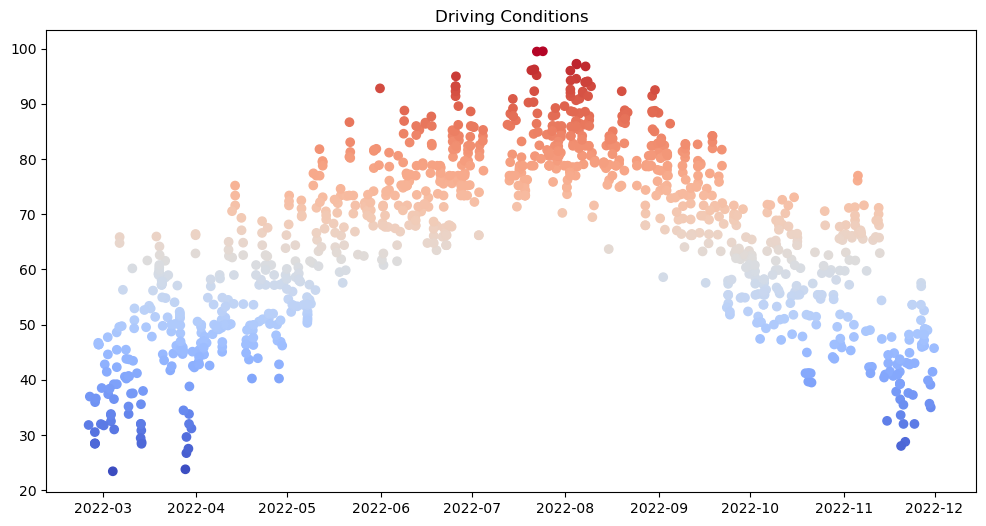

In [52]:
# temp
# my_fmt = mdates.DateFormatter('%d')
# months = mdates.MonthLocator()  # every month

x = trips['start_date']
y = trips['temp']
plt.scatter(x,y, c = trips.loc[:,'temp'], cmap = 'coolwarm')
plt.title("Driving Conditions")

# ax.xaxis.set_major_formatter(my_fmt);

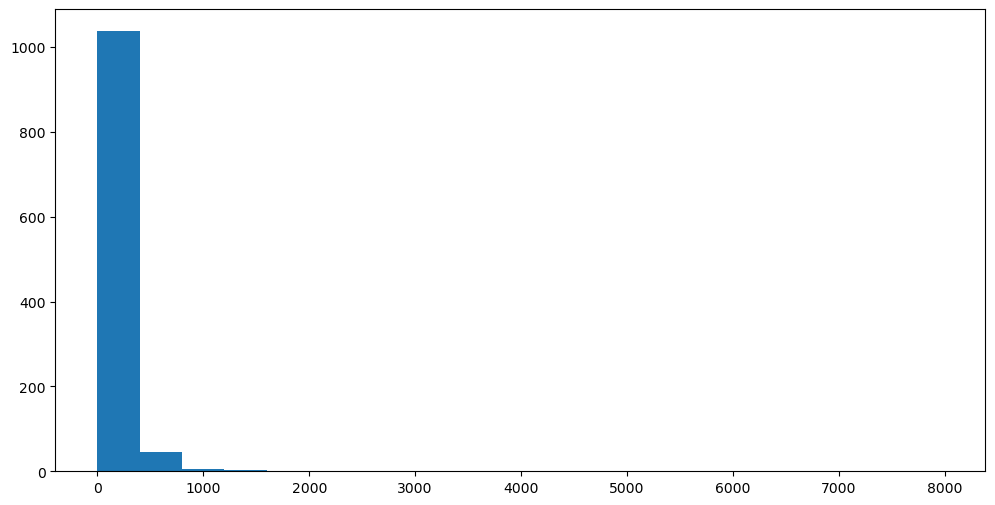

In [53]:
# start_range
y = trips['start_range']
plt.hist(y,bins=20);

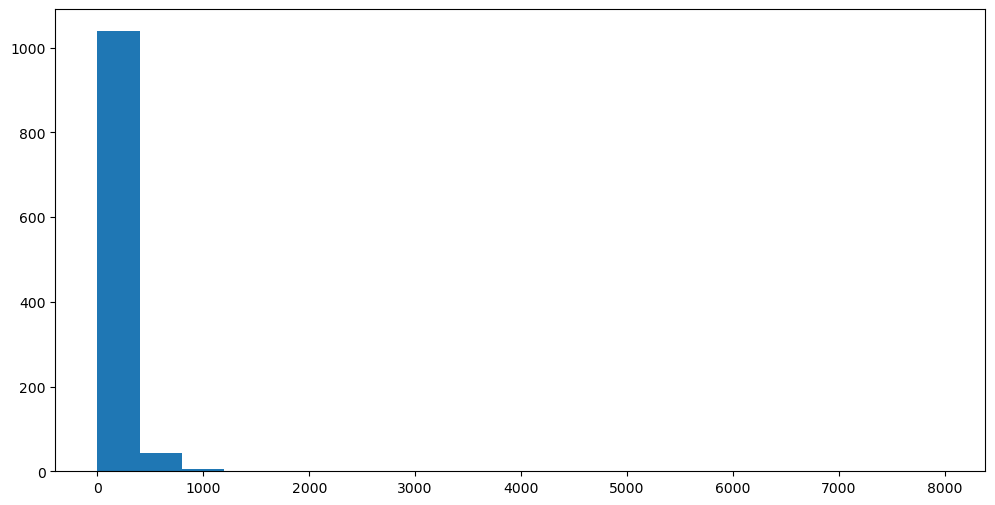

In [54]:
# end_range
y = trips['end_range']
plt.hist(y,bins=20);

In [55]:
trips[trips[r'mikWh']<15]

start_date            end_date  duration  distance  \
12   2022-11-19 12:38:37 2022-11-19 12:45:15  00:06:38      1.84   
13   2022-10-09 11:00:19 2022-10-09 11:07:53  00:07:34      2.88   
14   2022-07-18 17:25:26 2022-07-18 17:32:27  00:07:01      1.86   
15   2022-06-09 15:19:40 2022-06-09 15:28:55  00:09:15      2.55   
16   2022-06-29 19:27:20 2022-06-29 19:33:55  00:06:35      1.85   
17   2022-09-10 11:55:48 2022-09-10 11:58:48  00:03:00      0.46   
18   2022-03-31 17:02:15 2022-03-31 17:13:20  00:11:05      3.21   
19   2022-03-05 16:01:15 2022-03-05 16:18:03  00:16:48      1.48   
20   2022-10-06 16:10:44 2022-10-06 16:27:53  00:17:09      3.30   
21   2022-09-25 16:40:15 2022-09-25 16:52:53  00:12:38      3.60   
22   2022-05-17 12:48:04 2022-05-17 13:01:30  00:13:26      3.27   
23   2022-07-28 08:42:50 2022-07-28 08:45:40  00:02:50      1.16   
24   2022-09-26 11:25:30 2022-09-26 11:34:17  00:08:47      1.98   
25   2022-08-02 18:05:34 2022-08-02 18:13:45  00:08:11      1.85   
26   2022-06-03 16:07:57 2022-06-03 16:13:20  00:05:23      1.50   
27   2022-04-05 17:38:01 2022-04-05 17:49:51  00:11:50      3.68   
28   2022-10-31 13:47:08 2022-10-31 13:58:20  00:11:12      3.46   
29   2022-06-22 13:01:04 2022-06-22 13:13:24  00:12:20      3.36   
30   2022-10-22 21:40:35 2022-10-22 21:48:48  00:08:13      3.53   
31   2022-05-10 15:52:50 2022-05-10 16:04:04  00:11:14      3.62   
32   2022-05-03 16:12:47 2022-05-03 16:20:31  00:07:44      1.83   
33   2022-08-05 11:09:16 2022-08-05 11:20:14  00:10:58      5.67   
34   2022-09-01 07:03:35 2022-09-01 07:08:50  00:05:15      1.70   
35   2022-09-26 09:38:57 2022-09-26 09:53:40  00:14:43      6.10   
36   2022-04-13 19:12:02 2022-04-13 19:22:19  00:10:17      3.08   
37   2022-04-12 19:36:09 2022-04-12 19:37:45  00:01:36      0.18   
38   2022-10-01 16:00:58 2022-10-01 16:12:06  00:11:08      5.67   
39   2022-10-10 13:31:30 2022-10-10 13:46:19  00:14:49      5.61   
40   2022-06-24 16:02:04 2022-06-24 16:12:45  00:10:41      4.44   
41   2022-05-07 13:44:25 2022-05-07 13:49:08  00:04:43      0.71   
42   2022-05-11 08:20:50 2022-05-11 08:27:40  00:06:50      1.68   
43   2022-04-23 21:12:12 2022-04-23 21:22:37  00:10:25      2.97   
44   2022-10-02 16:52:53 2022-10-02 17:02:17  00:09:24      3.47   
45   2022-09-15 16:09:52 2022-09-15 16:17:12  00:07:20      1.98   
46   2022-04-08 16:17:05 2022-04-08 16:34:53  00:17:48      5.55   
47   2022-08-17 14:00:07 2022-08-17 14:12:59  00:12:52      5.69   
48   2022-06-23 17:56:21 2022-06-23 18:04:09  00:07:48      1.84   
49   2022-09-14 16:19:13 2022-09-14 16:26:12  00:06:59      2.76   
50   2022-04-02 14:44:47 2022-04-02 14:55:59  00:11:12      3.65   
51   2022-08-03 14:19:46 2022-08-03 14:28:26  00:08:40      3.05   
52   2022-03-20 13:01:57 2022-03-20 13:11:53  00:09:56      3.61   
53   2022-09-08 18:42:51 2022-09-08 18:48:30  00:05:39      1.70   
54   2022-09-03 15:16:18 2022-09-03 15:23:45  00:07:27      1.61   
55   2022-09-30 18:00:06 2022-09-30 18:11:07  00:11:01      3.60   
56   2022-10-05 15:28:48 2022-10-05 15:47:34  00:18:46      6.14   
57   2022-08-06 11:14:25 2022-08-06 11:23:51  00:09:26      1.91   
58   2022-06-09 09:50:08 2022-06-09 10:00:35  00:10:27      3.24   
59   2022-09-18 14:46:02 2022-09-18 14:58:42  00:12:40      5.68   
60   2022-10-10 10:25:20 2022-10-10 10:32:11  00:06:51      3.07   
61   2022-04-15 20:25:46 2022-04-15 20:33:15  00:07:29      1.65   
62   2022-11-27 18:24:23 2022-11-27 18:31:18  00:06:55      1.80   
63   2022-06-23 13:50:10 2022-06-23 13:57:13  00:07:03      2.58   
64   2022-07-16 18:38:16 2022-07-16 18:55:02  00:16:46      7.43   
65   2022-11-01 16:16:45 2022-11-01 16:25:33  00:08:48      3.39   
66   2022-07-18 11:21:47 2022-07-18 11:30:39  00:08:52      3.14   
67   2022-06-26 18:41:48 2022-06-26 18:50:22  00:08:34      3.44   
68   2022-09-23 17:33:06 2022-09-23 17:42:25  00:09:19      3.44   
69   2022-09-08 20:20:32 2022-09-08 20:29:50  00:09:18      3.28   
70

In [56]:
# temp = trips[trips[r'mi/kWh']<15]
# x = temp[r'mi/kWh']
# y = temp[r'Ambient Temperature (F)']
# a, b = np.polyfit(x, y, 1)

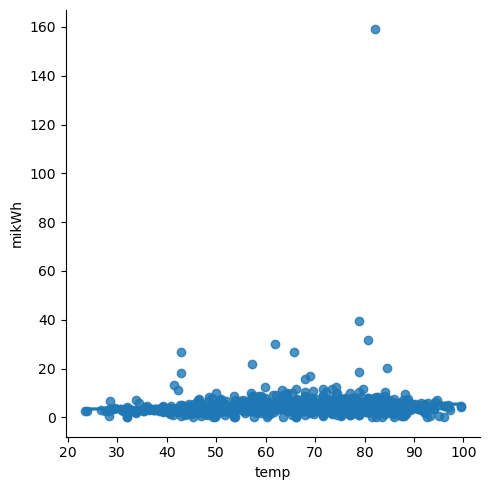

In [57]:
sns.lmplot(y = r'mikWh', x = r'temp', data = trips)


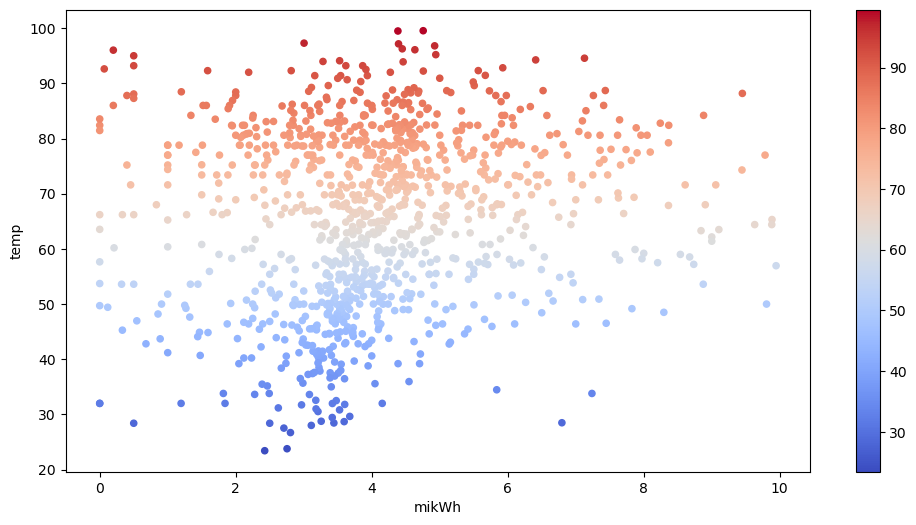

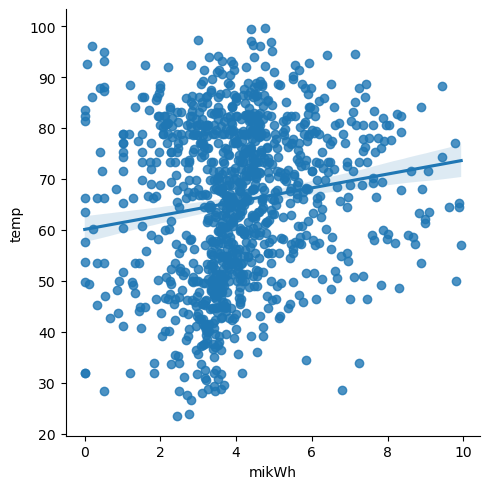

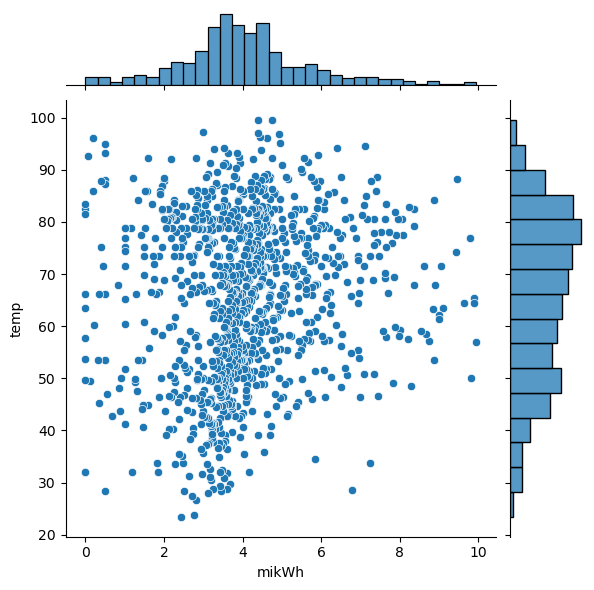

In [58]:
temp = trips[trips[r'mikWh']<10]
temp.plot(r'mikWh', r'temp', kind = 'scatter',\
                                c = trips.loc[trips[r'mikWh']<10,:][r'temp'],\
                                colormap = 'coolwarm',  alpha = 1, sharex=False)


sns.lmplot(x = r'mikWh', y = r'temp', data = temp)
sns.jointplot(x = r'mikWh', y = r'temp', data = temp)
# temp.plot(x, a*x+b) 




In [59]:
# import numpy as np
# import matplotlib.pyplot as plt

# #define data
# x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
# y = np.array([2, 5, 6, 7, 9, 12, 16, 19])

# #find line of best fit
# a, b = np.polyfit(x, y, 1)

# #add points to plot
# plt.scatter(x, y, color='purple')

# #add line of best fit to plot
# plt.plot(x, a*x+b, color='steelblue', linestyle='--', linewidth=2)

# #add fitted regression equation to plot
# plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

# NEED TO FIX DURATION dtype

In [60]:



# gas_prices['Duration'] = pd.datetime.time to_datetime(gas_prices['date'])
# gas_prices.dtypes

## gas_prices
NY Regular grade gasoline averages per week dating back to year 2000

In [61]:
# Skipping first 7 rows of data because it's the def section

weekly_gas_prices = pd.read_csv('data/RAW-NY_Gas_prices_REGULAR_FORMULA_Weekly_Retail_Gasoline_and_Diesel_Prices.csv'\
                    , skiprows = 7, names = ['date','price'])

weekly_gas_prices.head()

date  price
0  12/12/22  3.441
1   12/5/22  3.586
2  11/28/22  3.663
3  11/21/22  3.735
4  11/14/22  3.808

In [62]:
# Converting column 'date' to datetime
weekly_gas_prices['date'] = pd.to_datetime(weekly_gas_prices['date'])
weekly_gas_prices = weekly_gas_prices.rename(columns = {'date':'gas_price_date','price':'gas_price'})
weekly_gas_prices

gas_price_date  gas_price
0        2022-12-12      3.441
1        2022-12-05      3.586
2        2022-11-28      3.663
3        2022-11-21      3.735
4        2022-11-14      3.808
5        2022-11-07      3.832
6        2022-10-31      3.741
7        2022-10-24      3.586
8        2022-10-17      3.612
9        2022-10-10      3.557
10       2022-10-03      3.483
11       2022-09-26      3.542
12       2022-09-19      3.637
13       2022-09-12      3.740
14       2022-09-05      3.838
15       2022-08-29      3.994
16       2022-08-22      4.090
17       2022-08-15      4.173
18       2022-08-08      4.261
19       2022-08-01      4.359
20       2022-07-25      4.441
21       2022-07-18      4.536
22       2022-07-11      4.640
23       2022-07-04      4.757
24       2022-06-27      4.827
25       2022-06-20      4.884
26       2022-06-13      4.938
27       2022-06-06      4.767
28       2022-05-30      4.853
29       2022-05-23      4.850
30       2022-05-16      4.734
31       2022-05-09      4.463
32       2022-05-02      4.260
33       2022-04-25      4.119
34       2022-04-18      4.055
35       2022-04-11      4.104
36       2022-04-04      4.163
37       2022-03-28      4.236
38       2022-03-21      4.278
39       2022-03-14      4.365
40       2022-03-07      4.300
41       2022-02-28      3.750
42       2022-02-21      3.692
43       2022-02-14      3.639
44       2022-02-07      3.524
45       2022-01-31      3.470
46       2022-01-24      3.416
47       2022-01-17      3.393
48       2022-01-10      3.398
49       2022-01-03      3.419
50       2021-12-27      3.428
51       2021-12-20      3.438
52       2021-12-13      3.446
53       2021-12-06      3.451
54       2021-11-29      3.496
55       2021-11-22      3.497
56       2021-11-15      3.499
57       2021-11-08      3.492
58       2021-11-01      3.487
59       2021-10-25      3.476
60       2021-10-18      3.402
61       2021-10-11      3.308
62       2021-10-04      3.212
63       2021-09-27      3.218
64       2021-09-20      3.226
65       2021-09-13      3.224
66       2021-09-06      3.227
67       2021-08-30      3.172
68       2021-08-23      3.141
69       2021-08-16      3.146
70       2021-08-09      3.135
71       2021-08-02      3.149
72       2021-07-26      3.117
73       2021-07-19      3.126
74       2021-07-12      3.125
75       2021-07-05      3.112
76       2021-06-28      3.080
77       2021-06-21      3.070
78       2021-06-14      3.057
79       2021-06-07      3.010
80       2021-05-31      2.983
81       2021-05-24      2.988
82       2021-05-17      2.977
83       2021-05-10      2.938
84       2021-05-03      2.865
85       2021-04-26      2.829
86       2021-04-19      2.797
87       2021-04-12      2.796
88       2021-04-05      2.824
89       2021-03-29      2.823
90       2021-03-22      2.831
91       2021-03-15      2.825
92       2021-03-08      2.769
93       2021-03-01      2.733
94       2021-02-22      2.643
95       2021-02-15      2.532
96       2021-02-08      2.491
97       2021-02-01      2.448
98       2021-01-25      2.439
99       2021-01-18      2.404
100      2021-01-11      2.313
101      2021-01-04      2.256
102      2020-12-28      2.242
103      2020-12-21      2.241
104      2020-12-14      2.175
105      2020-12-07      2.167
106      2020-11-30      2.147
107      2020-11-23      2.149
108      2020-11-16      2.150
109      2020-11-09      2.142
110      2020-11-02      2.146
111      2020-10-26      2.159
112      2020-10-19      2.167
113      2020-10-12      2.164
114      2020-10-05      2.163
115      2020-09-28      2.170
116      2020-09-21      2.179
117      2020-09-14      2.198
118      2020-09-07      2.227
119      2020-08-31      2.235
120      2020-08-24      2.163
121      2020-08-17      2.173
122      2020-08-10      2.178
123      2020-08-03      2.189
124      2020-07-27      2.194
125      2020-07-20      2.204
126      2020-07-13      2.198
127      2020-07-06      2.192
128   

In [63]:
# limiting data to 2022
weekly_gas_prices = weekly_gas_prices[weekly_gas_prices['gas_price_date'].dt.year == 2022]
weekly_gas_prices

gas_price_date  gas_price
0      2022-12-12      3.441
1      2022-12-05      3.586
2      2022-11-28      3.663
3      2022-11-21      3.735
4      2022-11-14      3.808
5      2022-11-07      3.832
6      2022-10-31      3.741
7      2022-10-24      3.586
8      2022-10-17      3.612
9      2022-10-10      3.557
10     2022-10-03      3.483
11     2022-09-26      3.542
12     2022-09-19      3.637
13     2022-09-12      3.740
14     2022-09-05      3.838
15     2022-08-29      3.994
16     2022-08-22      4.090
17     2022-08-15      4.173
18     2022-08-08      4.261
19     2022-08-01      4.359
20     2022-07-25      4.441
21     2022-07-18      4.536
22     2022-07-11      4.640
23     2022-07-04      4.757
24     2022-06-27      4.827
25     2022-06-20      4.884
26     2022-06-13      4.938
27     2022-06-06      4.767
28     2022-05-30      4.853
29     2022-05-23      4.850
30     2022-05-16      4.734
31     2022-05-09      4.463
32     2022-05-02      4.260
33     2022-04-25      4.119
34     2022-04-18      4.055
35     2022-04-11      4.104
36     2022-04-04      4.163
37     2022-03-28      4.236
38     2022-03-21      4.278
39     2022-03-14      4.365
40     2022-03-07      4.300
41     2022-02-28      3.750
42     2022-02-21      3.692
43     2022-02-14      3.639
44     2022-02-07      3.524
45     2022-01-31      3.470
46     2022-01-24      3.416
47     2022-01-17      3.393
48     2022-01-10      3.398
49     2022-01-03      3.419

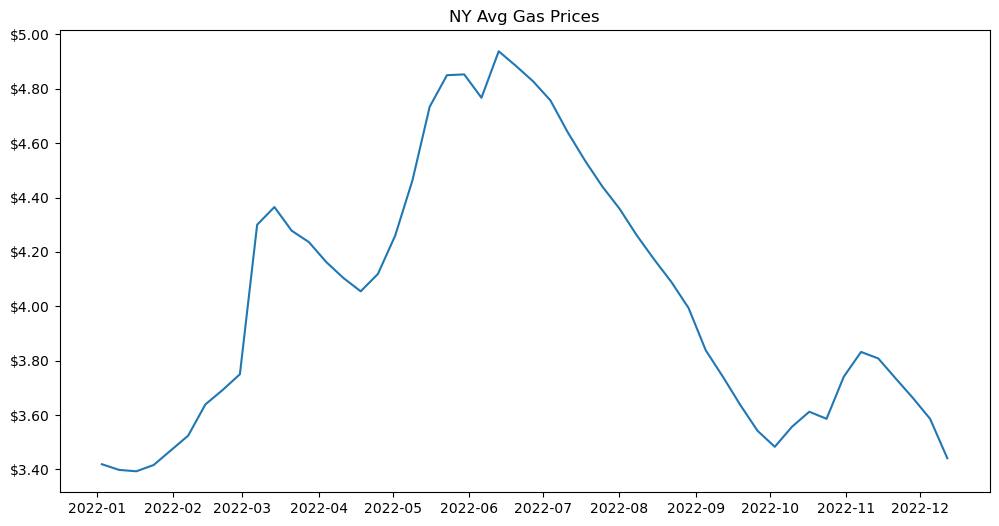

In [64]:
x = weekly_gas_prices.gas_price_date
y = weekly_gas_prices.gas_price

fig, ax = plt.subplots()
ax.plot(x, y)



def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)

# Labeling
plt.title('NY Avg Gas Prices')
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=12, maxticks=20))
ax.yaxis.set_major_formatter(dollar_format);




# Fill in missing dates, and copy values

In [65]:
# creating a range of dates, DataFrame
raw_dates = pd.DataFrame({'gas_price_date':pd.date_range('01-01-2022', '12-17-2022')})

# matching weekly gas prices to every single day
daily_gas_prices = pd.merge(raw_dates, weekly_gas_prices, how = 'outer',\
                            on = 'gas_price_date')

# .fillna to makesure every day of the week is filled, not just the one that matched previously.
daily_gas_prices = daily_gas_prices.fillna(method = 'ffill', inplace = False)

# I now have a weekly average that I can compare to a daily dataset.
daily_gas_prices


gas_price_date  gas_price
0       2022-01-01        NaN
1       2022-01-02        NaN
2       2022-01-03      3.419
3       2022-01-04      3.419
4       2022-01-05      3.419
5       2022-01-06      3.419
6       2022-01-07      3.419
7       2022-01-08      3.419
8       2022-01-09      3.419
9       2022-01-10      3.398
10      2022-01-11      3.398
11      2022-01-12      3.398
12      2022-01-13      3.398
13      2022-01-14      3.398
14      2022-01-15      3.398
15      2022-01-16      3.398
16      2022-01-17      3.393
17      2022-01-18      3.393
18      2022-01-19      3.393
19      2022-01-20      3.393
20      2022-01-21      3.393
21      2022-01-22      3.393
22      2022-01-23      3.393
23      2022-01-24      3.416
24      2022-01-25      3.416
25      2022-01-26      3.416
26      2022-01-27      3.416
27      2022-01-28      3.416
28      2022-01-29      3.416
29      2022-01-30      3.416
30      2022-01-31      3.470
31      2022-02-01      3.470
32      2022-02-02      3.470
33      2022-02-03      3.470
34      2022-02-04      3.470
35      2022-02-05      3.470
36      2022-02-06      3.470
37      2022-02-07      3.524
38      2022-02-08      3.524
39      2022-02-09      3.524
40      2022-02-10      3.524
41      2022-02-11      3.524
42      2022-02-12      3.524
43      2022-02-13      3.524
44      2022-02-14      3.639
45      2022-02-15      3.639
46      2022-02-16      3.639
47      2022-02-17      3.639
48      2022-02-18      3.639
49      2022-02-19      3.639
50      2022-02-20      3.639
51      2022-02-21      3.692
52      2022-02-22      3.692
53      2022-02-23      3.692
54      2022-02-24      3.692
55      2022-02-25      3.692
56      2022-02-26      3.692
57      2022-02-27      3.692
58      2022-02-28      3.750
59      2022-03-01      3.750
60      2022-03-02      3.750
61      2022-03-03      3.750
62      2022-03-04      3.750
63      2022-03-05      3.750
64      2022-03-06      3.750
65      2022-03-07      4.300
66      2022-03-08      4.300
67      2022-03-09      4.300
68      2022-03-10      4.300
69      2022-03-11      4.300
70      2022-03-12      4.300
71      2022-03-13      4.300
72      2022-03-14      4.365
73      2022-03-15      4.365
74      2022-03-16      4.365
75      2022-03-17      4.365
76      2022-03-18      4.365
77      2022-03-19      4.365
78      2022-03-20      4.365
79      2022-03-21      4.278
80      2022-03-22      4.278
81      2022-03-23      4.278
82      2022-03-24      4.278
83      2022-03-25      4.278
84      2022-03-26      4.278
85      2022-03-27      4.278
86      2022-03-28      4.236
87      2022-03-29      4.236
88      2022-03-30      4.236
89      2022-03-31      4.236
90      2022-04-01      4.236
91      2022-04-02      4.236
92      2022-04-03      4.236
93      2022-04-04      4.163
94      2022-04-05      4.163
95      2022-04-06      4.163
96      2022-04-07      4.163
97      2022-04-08      4.163
98      2022-04-09      4.163
99      2022-04-10      4.163
100     2022-04-11      4.104
101     2022-04-12      4.104
102     2022-04-13      4.104
103     2022-04-14      4.104
104     2022-04-15      4.104
105     2022-04-16      4.104
106     2022-04-17      4.104
107     2022-04-18      4.055
108     2022-04-19      4.055
109     2022-04-20      4.055
110     2022-04-21      4.055
111     2022-04-22      4.055
112     2022-04-23      4.055
113     2022-04-24      4.055
114     2022-04-25      4.119
115     2022-04-26      4.119
116     2022-04-27      4.119
117     2022-04-28      4.119
118     2022-04-29      4.119
119     2022-04-30      4.119
120     2022-05-01      4.119
121     2022-05-02      4.260
122     2022-05-03      4.260
123     2022-05-04      4.260
124     2022-05-05      4.260
125     2022-05-06      4.260
126     2022-05-07      4.260
127     2022-05-08      4.260
128     2022-05-09      4.463
129     2022-05-10      4.463
130     2022-05-11      4.463
131     2022-05-12      4.463
132     2022-0

## Append Gas Data cost to trips

In [66]:
# temporary create new column to easily merge on date data (avoid complicatino of merging datetime to date)
trips['start_date_iso'] = pd.to_datetime(trips.start_date.dt.date)

# merge gas prices on trips DataFrame
trips = pd.merge(trips, daily_gas_prices, left_on = 'start_date_iso', right_on = 'gas_price_date')

# drop temp column and redundent gas_price_date
trips.drop(columns = ['start_date_iso','gas_price_date'], inplace = True)


trips


start_date            end_date  duration  distance  \
0    2022-06-25 20:18:33 2022-06-25 20:25:43  00:07:10      1.59   
1    2022-06-25 15:45:32 2022-06-25 15:50:47  00:05:15      0.76   
2    2022-06-25 16:00:32 2022-06-25 16:06:55  00:06:23      1.24   
3    2022-06-25 20:28:57 2022-06-25 20:35:15  00:06:18      1.44   
4    2022-06-25 10:42:28 2022-06-25 10:48:40  00:06:12      1.36   
5    2022-06-25 20:00:49 2022-06-25 20:06:28  00:05:39      1.83   
6    2022-06-25 15:52:50 2022-06-25 15:57:57  00:05:07      0.73   
7    2022-06-25 16:23:29 2022-06-25 16:23:56  00:00:27      0.01   
8    2022-06-25 18:43:56 2022-06-25 18:44:23  00:00:27      0.01   
9    2022-07-16 20:43:47 2022-07-16 20:48:01  00:04:14      0.79   
10   2022-07-16 18:38:16 2022-07-16 18:55:02  00:16:46      7.43   
11   2022-07-16 11:47:14 2022-07-16 12:04:56  00:17:42      7.43   
12   2022-07-16 19:09:22 2022-07-16 19:13:37  00:04:15      0.97   
13   2022-07-16 21:22:40 2022-07-16 21:32:25  00:09:45      1.83   
14   2022-07-16 10:26:18 2022-07-16 10:26:55  00:00:37      0.02   
15   2022-07-26 16:16:48 2022-07-26 16:23:35  00:06:47      1.91   
16   2022-07-26 11:18:03 2022-07-26 11:30:21  00:12:18      5.60   
17   2022-07-26 14:46:26 2022-07-26 14:51:56  00:05:30      1.22   
18   2022-07-26 13:44:30 2022-07-26 13:50:01  00:05:31      1.18   
19   2022-07-26 10:34:12 2022-07-26 10:46:56  00:12:44      5.82   
20   2022-07-26 10:54:39 2022-07-26 10:56:21  00:01:42      0.11   
21   2022-07-26 15:22:09 2022-07-26 15:28:54  00:06:45      1.87   
22   2022-05-18 20:33:28 2022-05-18 20:39:32  00:06:04      1.81   
23   2022-05-18 17:13:57 2022-05-18 17:23:54  00:09:57      3.40   
24   2022-05-18 19:41:59 2022-05-18 20:22:08  00:40:09     34.28   
25   2022-05-18 15:45:55 2022-05-18 16:37:16  00:51:21     46.37   
26   2022-05-18 08:06:53 2022-05-18 08:37:22  00:30:29     16.11   
27   2022-11-03 16:38:58 2022-11-03 16:43:54  00:04:56      1.60   
28   2022-11-03 16:49:02 2022-11-03 17:18:51  00:29:49     16.77   
29   2022-11-03 07:22:40 2022-11-03 07:55:37  00:32:57     17.82   
30   2022-11-22 12:44:33 2022-11-22 12:49:55  00:05:22      1.60   
31   2022-11-22 15:58:29 2022-11-22 16:32:36  00:34:07     17.71   
32   2022-11-22 18:06:40 2022-11-22 18:15:01  00:08:21      1.85   
33   2022-11-22 08:00:50 2022-11-22 08:27:50  00:27:00     17.77   
34   2022-11-22 12:55:54 2022-11-22 13:11:41  00:15:47      1.60   
35   2022-11-22 17:27:36 2022-11-22 17:34:59  00:07:23      1.57   
36   2022-03-20 11:50:07 2022-03-20 11:56:40  00:06:33      2.40   
37   2022-03-20 13:01:57 2022-03-20 13:11:53  00:09:56      3.61   
38   2022-03-20 11:23:08 2022-03-20 11:28:26  00:05:18      1.19   
39   2022-03-20 16:16:17 2022-03-20 17:13:55  00:57:38     34.20   
40   2022-03-20 20:36:39 2022-03-20 21:21:54  00:45:15     32.96   
41   2022-03-20 12:16:53 2022-03-20 12:27:38  00:10:45      3.55   
42   2022-03-20 15:55:31 2022-03-20 16:11:37  00:16:06      5.84   
43   2022-03-20 11:31:23 2022-03-20 11:40:06  00:08:43      1.61   
44   2022-03-20 20:09:52 2022-03-20 20:11:49  00:01:57      0.05   
45   2022-03-20 13:20:44 2022-03-20 13:21:05  00:00:21      0.01   
46   2022-07-21 11:11:44 2022-07-21 11:15:37  00:03:53      0.81   
47   2022-07-21 16:04:22 2022-07-21 16:49:54  00:45:32     25.05   
48   2022-07-21 21:25:14 2022-07-21 22:09:38  00:44:24     32.98   
49   2022-07-21 16:55:45 2022-07-21 17:10:36  00:14:51      6.94   
50   2022-07-21 10:45:23 2022-07-21 10:50:28  00:05:05      1.19   
51   2022-07-21 11:32:10 2022-07-21 11:40:41  00:08:31      1.88   
52   2022-07-17 20:35:08 2022-07-17 20:44:47  00:09:39      1.85   
53   2022-07-17 11:23:59 2022-07-17 11:33:38  00:09:39      3.62   
54   2022-07-17 10:04:33 2022-07-17 10:22:07  00:17:34      4.33   
55   2022-07-17 10:47:44 2022-07-17 10:51:45  00:04:01      0.60   
56   2022-07-17 20:23:17 2022-07-17 20:30:02  00:06:45      1.51   
57   2022-04-28 06:57:30 2022-04-28 06:59:52  00:02:22      1.28   
58

In [67]:
# Our other car is a 2005 Toyota Corolla and gets 32/41 mpg, it's an old car so let's assume it's mpg is on the lower end
trips['gas_used_eq'] = trips.distance/32
trips['trip_cost_gas_car_eq'] = trips.gas_used_eq * trips.gas_price

trips.sort_values('distance', ascending = False)

start_date            end_date  duration  distance  \
949  2022-10-07 17:00:35 2022-10-07 20:48:53  03:48:18    177.48   
950  2022-10-07 21:41:25 2022-10-08 00:50:02  03:08:37    174.21   
919  2022-06-10 11:17:29 2022-06-10 14:59:28  03:41:59    173.95   
769  2022-06-12 20:04:52 2022-06-12 23:01:39  02:56:47    168.57   
84   2022-10-09 20:33:10 2022-10-09 23:33:32  03:00:22    168.05   
835  2022-07-24 12:29:30 2022-07-24 15:40:12  03:10:42    161.11   
661  2022-06-30 08:37:15 2022-06-30 11:31:55  02:54:40    155.14   
702  2022-07-03 15:42:11 2022-07-03 18:11:01  02:28:50    150.60   
991  2022-08-09 18:16:41 2022-08-09 20:50:26  02:33:45    146.22   
767  2022-06-12 15:59:48 2022-06-12 18:26:41  02:26:53    128.90   
894  2022-08-20 13:58:21 2022-08-20 16:12:22  02:14:01    122.70   
349  2022-08-27 17:52:01 2022-08-27 19:58:28  02:06:27    122.55   
82   2022-10-09 15:48:48 2022-10-09 19:01:57  03:13:09    121.44   
893  2022-08-20 16:42:48 2022-08-20 18:51:46  02:08:58    104.87   
427  2022-03-11 12:20:09 2022-03-11 14:12:03  01:51:54    101.42   
921  2022-06-10 08:39:29 2022-06-10 10:15:33  01:36:04    100.56   
863  2022-06-08 19:26:11 2022-06-08 21:16:12  01:50:01     99.54   
1018 2022-10-28 15:51:48 2022-10-28 17:58:05  02:06:17     99.34   
674  2022-09-09 16:02:22 2022-09-09 18:01:08  01:58:46     97.26   
618  2022-08-14 09:10:49 2022-08-14 11:10:31  01:59:42     95.25   
962  2022-08-13 17:50:42 2022-08-13 19:42:23  01:51:41     94.51   
994  2022-03-13 15:47:36 2022-03-13 18:02:45  02:15:09     93.06   
990  2022-08-09 21:15:09 2022-08-09 22:54:43  01:39:34     90.90   
794  2022-07-22 12:45:47 2022-07-22 14:32:33  01:46:46     90.46   
963  2022-08-13 14:37:25 2022-08-13 16:09:06  01:31:41     90.27   
887  2022-05-08 13:09:03 2022-05-08 15:00:57  01:51:54     88.20   
1020 2022-10-28 21:18:44 2022-10-28 22:50:13  01:31:29     81.20   
573  2022-09-11 09:49:08 2022-09-11 11:05:30  01:16:22     78.06   
860  2022-06-08 06:46:47 2022-06-08 08:03:47  01:17:00     74.58   
792  2022-07-22 10:55:16 2022-07-22 12:37:48  01:42:32     72.94   
920  2022-06-10 07:11:03 2022-06-10 08:36:47  01:25:44     67.51   
660  2022-06-30 12:40:54 2022-06-30 13:59:37  01:18:43     67.25   
964  2022-08-13 16:40:31 2022-08-13 17:47:54  01:07:23     64.92   
842  2022-06-19 18:42:40 2022-06-19 20:29:19  01:46:39     63.77   
852  2022-03-19 18:38:02 2022-03-19 20:07:12  01:29:10     62.99   
997  2022-03-13 13:26:32 2022-03-13 14:39:43  01:13:11     62.23   
612  2022-07-04 18:11:49 2022-07-04 19:29:57  01:18:08     61.45   
907  2022-07-12 19:48:47 2022-07-12 21:08:26  01:19:39     60.18   
929  2022-04-09 13:27:01 2022-04-09 15:12:36  01:45:35     58.99   
854  2022-03-19 10:21:28 2022-03-19 11:54:53  01:33:25     58.80   
701  2022-07-03 13:50:04 2022-07-03 14:58:14  01:08:10     58.42   
791  2022-07-25 21:45:45 2022-07-25 23:55:11  02:09:26     58.27   
803  2022-04-30 11:06:03 2022-04-30 12:42:48  01:36:45     58.24   
1084 2022-02-28 16:14:45 2022-02-28 17:52:01  01:37:16     58.23   
572  2022-09-11 12:29:17 2022-09-11 13:38:51  01:09:34     58.08   
348  2022-08-27 16:28:49 2022-08-27 17:35:18  01:06:29     57.59   
757  2022-06-14 07:01:46 2022-06-14 08:46:33  01:44:47     57.12   
758  2022-06-14 19:35:25 2022-06-14 20:46:59  01:11:34     56.82   
931  2022-04-09 22:51:31 2022-04-10 00:16:18  01:24:47     56.39   
804  2022-04-30 17:44:17 2022-04-30 19:29:47  01:45:30     55.94   
845  2022-10-15 13:54:22 2022-10-15 15:33:49  01:39:27     54.82   
790  2022-07-25 19:43:56 2022-07-25 20:57:46  01:13:50     54.12   
815  2022-04-03 17:34:39 2022-04-03 18:45:45  01:11:06     52.67   
969  2022-11-11 17:39:09 2022-11-11 19:29:05  01:49:56     52.61   
970  2022-11-11 13:03:36 2022-11-11 14:40:05  01:36:29     52.33   
816  2022-04-03 11:46:03 2022-04-03 12:59:41  01:13:38     52.27   
473  2022-02-26 11:36:28 2022-02-26 12:54:09  01:17:41     52.26   
841  2022-06-19 08:47:19 2022-06-19 09:53:16  01:05:57     52.02   
98

## Scraping utility bill .pdfs for electricity prices

In [68]:
directory = 'data/utility_bills'

# lists to populate
bill_dates = []
supply_charge_rate = []
delivery_charge_rate = []

# iterate over utility bill .pdfs in directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    
    if os.path.isfile(f): # checking if it is a file
        with open(f,'rb') as file:
            reader = PyPDF2.PdfReader(f)
            page = reader.pages[1].extract_text() # 2nd page and extracted text
        
        bill_dates.append(re.findall('Electric Meter Detail - billing period from (\w+ \w+, \w+)  to (\w+ \w+, \w+)', page))
        supply_charge_rate.append(re.findall('Supply \d{0,2},*\d{2,5} \s{0,1}kWh @(\d{1,2}.\d{1,5})', page))
        delivery_charge_rate.append(re.findall('Delivery \d{0,2},*\d{2,5} kWh @(\d{1,2}.\d{1,5})', page))
       
    
print(bill_dates)
print('-'*56)
print(supply_charge_rate)
print('-'*56)
print(delivery_charge_rate)



[[('May 20, 2022', 'Jun 21, 2022')], [('Dec 21, 2021', 'Jan 21, 2022')], [('Sep 20, 2021', 'Oct 20, 2021')], [('Oct 20, 2021', 'Nov 18, 2021')], [('Jan 21, 2022', 'Feb 22, 2022')], [('Sep 20, 2022', 'Oct 20, 2022')], [('Jun 21, 2022', 'Jul 21, 2022')], [('Feb 22, 2022', 'Mar 23, 2022')], [('Jul 28, 2021', 'Aug 19, 2021')], [('Oct 20, 2022', 'Nov 18, 2022')], [('Jul 21, 2022', 'Aug 19, 2022')], [('Mar 23, 2022', 'Apr 21, 2022')], [('Nov 18, 2021', 'Dec 21, 2021')], [('Apr 21, 2022', 'May 20, 2022')], [('Aug 19, 2021', 'Sep 20, 2021')], [('Aug 19, 2022', 'Sep 20, 2022')]]
--------------------------------------------------------
[['10.9766'], ['12.9075'], ['7.5975'], ['6.9020'], ['7.9374'], ['11.0633'], ['7.1050'], ['7.9757'], ['7.6314'], ['9.7383'], ['11.0549'], ['9.9120'], ['5.6295'], ['10.3918'], ['7.6119'], ['11.0379']]
--------------------------------------------------------
[['15.1348'], ['13.1940'], ['12.8408'], ['12.4989'], ['12.1079'], ['15.7478'], ['14.8014'], ['13.5178'], ['13.

In [69]:
# flatten out list of lists
bill_dates_flat = [num for sublist in bill_dates for num in sublist]
supply_charge_rate_flat = [num for sublist in supply_charge_rate for num in sublist]
delivery_charge_rate_flat = [num for sublist in delivery_charge_rate for num in sublist]

# unpack tuples
bill_start = []
bill_end = []
for i in bill_dates_flat:
    bill_start.append(i[0])
    bill_end.append(i[1])


print(bill_start)
print('-'*56)
print(bill_end)
print('-'*56)
print(supply_charge_rate_flat)
print('-'*56)
print(delivery_charge_rate_flat)

['May 20, 2022', 'Dec 21, 2021', 'Sep 20, 2021', 'Oct 20, 2021', 'Jan 21, 2022', 'Sep 20, 2022', 'Jun 21, 2022', 'Feb 22, 2022', 'Jul 28, 2021', 'Oct 20, 2022', 'Jul 21, 2022', 'Mar 23, 2022', 'Nov 18, 2021', 'Apr 21, 2022', 'Aug 19, 2021', 'Aug 19, 2022']
--------------------------------------------------------
['Jun 21, 2022', 'Jan 21, 2022', 'Oct 20, 2021', 'Nov 18, 2021', 'Feb 22, 2022', 'Oct 20, 2022', 'Jul 21, 2022', 'Mar 23, 2022', 'Aug 19, 2021', 'Nov 18, 2022', 'Aug 19, 2022', 'Apr 21, 2022', 'Dec 21, 2021', 'May 20, 2022', 'Sep 20, 2021', 'Sep 20, 2022']
--------------------------------------------------------
['10.9766', '12.9075', '7.5975', '6.9020', '7.9374', '11.0633', '7.1050', '7.9757', '7.6314', '9.7383', '11.0549', '9.9120', '5.6295', '10.3918', '7.6119', '11.0379']
--------------------------------------------------------
['15.1348', '13.1940', '12.8408', '12.4989', '12.1079', '15.7478', '14.8014', '13.5178', '13.2648', '13.9280', '14.8135', '13.8647', '12.3138', '13.

In [70]:
# creating dataframe from extracted data
utility_bill = pd.DataFrame({'bill_start': bill_start,
              'bill_end' : bill_end,
              'supply_charge_rate': supply_charge_rate_flat,
              'delivery_charge_rate' : delivery_charge_rate_flat
             })
# converting text dates, to datetime
utility_bill['bill_start'] = pd.to_datetime(utility_bill['bill_start'])
utility_bill['bill_end'] = pd.to_datetime(utility_bill['bill_end'])

# converting str to floats
utility_bill = utility_bill.astype({'supply_charge_rate': 'float', 'delivery_charge_rate': 'float'})

# adding up all fees to one combined electricity rate column
utility_bill['electric_price'] = (utility_bill.supply_charge_rate/100)+ (utility_bill.delivery_charge_rate/100)

# dropping the other rate columns
utility_bill.drop(columns = ['supply_charge_rate','delivery_charge_rate'], inplace = True)

# filtering to only 2022
utility_bill = utility_bill[utility_bill.bill_start.dt.year == 2022]

# creating a range of dates, DataFrame
raw_dates = pd.DataFrame({'bill_start':pd.date_range('01-01-2022', '12-17-2022')})

# matching weekly gas prices to every single day
daily_electric_prices = pd.merge(raw_dates, utility_bill, how = 'outer',\
                            on = 'bill_start')

# .fillna to makesure every day of the week is filled, not just the one that matched previously.
daily_electric_prices = daily_electric_prices.fillna(method = 'ffill', inplace = False)

# filtering to trips date range
daily_electric_prices = daily_electric_prices[daily_electric_prices.bill_start >= '2022-02-24']

# dropping bill_end date and renaming bill start
daily_electric_prices = daily_electric_prices.drop(columns = 'bill_end')
daily_electric_prices = daily_electric_prices.rename(columns = {'bill_start':'electric_price_date'})


# I now have a weekly average that I can compare to a daily dataset.
daily_electric_prices


electric_price_date  electric_price
54           2022-02-24        0.214935
55           2022-02-25        0.214935
56           2022-02-26        0.214935
57           2022-02-27        0.214935
58           2022-02-28        0.214935
59           2022-03-01        0.214935
60           2022-03-02        0.214935
61           2022-03-03        0.214935
62           2022-03-04        0.214935
63           2022-03-05        0.214935
64           2022-03-06        0.214935
65           2022-03-07        0.214935
66           2022-03-08        0.214935
67           2022-03-09        0.214935
68           2022-03-10        0.214935
69           2022-03-11        0.214935
70           2022-03-12        0.214935
71           2022-03-13        0.214935
72           2022-03-14        0.214935
73           2022-03-15        0.214935
74           2022-03-16        0.214935
75           2022-03-17        0.214935
76           2022-03-18        0.214935
77           2022-03-19        0.214935
78           2022-03-20        0.214935
79           2022-03-21        0.214935
80           2022-03-22        0.214935
81           2022-03-23        0.237767
82           2022-03-24        0.237767
83           2022-03-25        0.237767
84           2022-03-26        0.237767
85           2022-03-27        0.237767
86           2022-03-28        0.237767
87           2022-03-29        0.237767
88           2022-03-30        0.237767
89           2022-03-31        0.237767
90           2022-04-01        0.237767
91           2022-04-02        0.237767
92           2022-04-03        0.237767
93           2022-04-04        0.237767
94           2022-04-05        0.237767
95           2022-04-06        0.237767
96           2022-04-07        0.237767
97           2022-04-08        0.237767
98           2022-04-09        0.237767
99           2022-04-10        0.237767
100          2022-04-11        0.237767
101          2022-04-12        0.237767
102          2022-04-13        0.237767
103          2022-04-14        0.237767
104          2022-04-15        0.237767
105          2022-04-16        0.237767
106          2022-04-17        0.237767
107          2022-04-18        0.237767
108          2022-04-19        0.237767
109          2022-04-20        0.237767
110          2022-04-21        0.242539
111          2022-04-22        0.242539
112          2022-04-23        0.242539
113          2022-04-24        0.242539
114          2022-04-25        0.242539
115          2022-04-26        0.242539
116          2022-04-27        0.242539
117          2022-04-28        0.242539
118          2022-04-29        0.242539
119          2022-04-30        0.242539
120          2022-05-01        0.242539
121          2022-05-02        0.242539
122          2022-05-03        0.242539
123          2022-05-04        0.242539
124          2022-05-05        0.242539
125          2022-05-06        0.242539
126          2022-05-07        0.242539
127          2022-05-08        0.242539
128          2022-05-09        0.242539
129          2022-05-10        0.242539
130          2022-05-11        0.242539
131          2022-05-12        0.242539
132          2022-05-13        0.242539
133          2022-05-14        0.242539
134          2022-05-15        0.242539
135          2022-05-16        0.242539
136          2022-05-17        0.242539
137          2022-05-18        0.242539
138          2022-05-19        0.242539
139          2022-05-20        0.261114
140          2022-05-21        0.261114
141          2022-05-22        0.261114
142          2022-05-23        0.261114
143          2022-05-24        0.261114
144          2022-05-25        0.261114
145          2022-05-26        0.261114
146          2022-05-27        0.261114
147          2022-05-28        0.261114
148          2022-05-29        0.261114
149          2022-05-30        0.261114
150          2022-05-31        0.261114
151          2022-06-01        0.261114
152          2022-06-02        0.261114
153 

## Write Electric Prices to .csv

In [71]:
daily_electric_prices.to_csv('data/CLEAN-Scraped-utility-electricity-prices.csv', sep=',', encoding='utf-8')

## Append Electric Prices to Trips Dataset

In [72]:
# temporary create new column to easily merge on date data (avoid complicatino of merging datetime to date)
trips['start_date_iso'] = pd.to_datetime(trips.start_date.dt.date)

# merge electric prices on trips DataFrame
trips = pd.merge(trips, daily_electric_prices, left_on = 'start_date_iso', right_on = 'electric_price_date')

# drop temp column and redundent electric_price_date
trips.drop(columns = ['start_date_iso','electric_price_date'], inplace = True)


trips

start_date            end_date  duration  distance  \
0    2022-06-25 20:18:33 2022-06-25 20:25:43  00:07:10      1.59   
1    2022-06-25 15:45:32 2022-06-25 15:50:47  00:05:15      0.76   
2    2022-06-25 16:00:32 2022-06-25 16:06:55  00:06:23      1.24   
3    2022-06-25 20:28:57 2022-06-25 20:35:15  00:06:18      1.44   
4    2022-06-25 10:42:28 2022-06-25 10:48:40  00:06:12      1.36   
5    2022-06-25 20:00:49 2022-06-25 20:06:28  00:05:39      1.83   
6    2022-06-25 15:52:50 2022-06-25 15:57:57  00:05:07      0.73   
7    2022-06-25 16:23:29 2022-06-25 16:23:56  00:00:27      0.01   
8    2022-06-25 18:43:56 2022-06-25 18:44:23  00:00:27      0.01   
9    2022-07-16 20:43:47 2022-07-16 20:48:01  00:04:14      0.79   
10   2022-07-16 18:38:16 2022-07-16 18:55:02  00:16:46      7.43   
11   2022-07-16 11:47:14 2022-07-16 12:04:56  00:17:42      7.43   
12   2022-07-16 19:09:22 2022-07-16 19:13:37  00:04:15      0.97   
13   2022-07-16 21:22:40 2022-07-16 21:32:25  00:09:45      1.83   
14   2022-07-16 10:26:18 2022-07-16 10:26:55  00:00:37      0.02   
15   2022-07-26 16:16:48 2022-07-26 16:23:35  00:06:47      1.91   
16   2022-07-26 11:18:03 2022-07-26 11:30:21  00:12:18      5.60   
17   2022-07-26 14:46:26 2022-07-26 14:51:56  00:05:30      1.22   
18   2022-07-26 13:44:30 2022-07-26 13:50:01  00:05:31      1.18   
19   2022-07-26 10:34:12 2022-07-26 10:46:56  00:12:44      5.82   
20   2022-07-26 10:54:39 2022-07-26 10:56:21  00:01:42      0.11   
21   2022-07-26 15:22:09 2022-07-26 15:28:54  00:06:45      1.87   
22   2022-05-18 20:33:28 2022-05-18 20:39:32  00:06:04      1.81   
23   2022-05-18 17:13:57 2022-05-18 17:23:54  00:09:57      3.40   
24   2022-05-18 19:41:59 2022-05-18 20:22:08  00:40:09     34.28   
25   2022-05-18 15:45:55 2022-05-18 16:37:16  00:51:21     46.37   
26   2022-05-18 08:06:53 2022-05-18 08:37:22  00:30:29     16.11   
27   2022-11-03 16:38:58 2022-11-03 16:43:54  00:04:56      1.60   
28   2022-11-03 16:49:02 2022-11-03 17:18:51  00:29:49     16.77   
29   2022-11-03 07:22:40 2022-11-03 07:55:37  00:32:57     17.82   
30   2022-11-22 12:44:33 2022-11-22 12:49:55  00:05:22      1.60   
31   2022-11-22 15:58:29 2022-11-22 16:32:36  00:34:07     17.71   
32   2022-11-22 18:06:40 2022-11-22 18:15:01  00:08:21      1.85   
33   2022-11-22 08:00:50 2022-11-22 08:27:50  00:27:00     17.77   
34   2022-11-22 12:55:54 2022-11-22 13:11:41  00:15:47      1.60   
35   2022-11-22 17:27:36 2022-11-22 17:34:59  00:07:23      1.57   
36   2022-03-20 11:50:07 2022-03-20 11:56:40  00:06:33      2.40   
37   2022-03-20 13:01:57 2022-03-20 13:11:53  00:09:56      3.61   
38   2022-03-20 11:23:08 2022-03-20 11:28:26  00:05:18      1.19   
39   2022-03-20 16:16:17 2022-03-20 17:13:55  00:57:38     34.20   
40   2022-03-20 20:36:39 2022-03-20 21:21:54  00:45:15     32.96   
41   2022-03-20 12:16:53 2022-03-20 12:27:38  00:10:45      3.55   
42   2022-03-20 15:55:31 2022-03-20 16:11:37  00:16:06      5.84   
43   2022-03-20 11:31:23 2022-03-20 11:40:06  00:08:43      1.61   
44   2022-03-20 20:09:52 2022-03-20 20:11:49  00:01:57      0.05   
45   2022-03-20 13:20:44 2022-03-20 13:21:05  00:00:21      0.01   
46   2022-07-21 11:11:44 2022-07-21 11:15:37  00:03:53      0.81   
47   2022-07-21 16:04:22 2022-07-21 16:49:54  00:45:32     25.05   
48   2022-07-21 21:25:14 2022-07-21 22:09:38  00:44:24     32.98   
49   2022-07-21 16:55:45 2022-07-21 17:10:36  00:14:51      6.94   
50   2022-07-21 10:45:23 2022-07-21 10:50:28  00:05:05      1.19   
51   2022-07-21 11:32:10 2022-07-21 11:40:41  00:08:31      1.88   
52   2022-07-17 20:35:08 2022-07-17 20:44:47  00:09:39      1.85   
53   2022-07-17 11:23:59 2022-07-17 11:33:38  00:09:39      3.62   
54   2022-07-17 10:04:33 2022-07-17 10:22:07  00:17:34      4.33   
55   2022-07-17 10:47:44 2022-07-17 10:51:45  00:04:01      0.60   
56   2022-07-17 20:23:17 2022-07-17 20:30:02  00:06:45      1.51   
57   2022-04-28 06:57:30 2022-04-28 06:59:52  00:02:22      1.28   
58

In [73]:
# adding column for cost of electricity per trips

trips['trip_cost'] = trips.electricity_used * trips.electric_price
trips.sort_values('distance', ascending = False)

start_date            end_date  duration  distance  \
949  2022-10-07 17:00:35 2022-10-07 20:48:53  03:48:18    177.48   
950  2022-10-07 21:41:25 2022-10-08 00:50:02  03:08:37    174.21   
919  2022-06-10 11:17:29 2022-06-10 14:59:28  03:41:59    173.95   
769  2022-06-12 20:04:52 2022-06-12 23:01:39  02:56:47    168.57   
84   2022-10-09 20:33:10 2022-10-09 23:33:32  03:00:22    168.05   
835  2022-07-24 12:29:30 2022-07-24 15:40:12  03:10:42    161.11   
661  2022-06-30 08:37:15 2022-06-30 11:31:55  02:54:40    155.14   
702  2022-07-03 15:42:11 2022-07-03 18:11:01  02:28:50    150.60   
991  2022-08-09 18:16:41 2022-08-09 20:50:26  02:33:45    146.22   
767  2022-06-12 15:59:48 2022-06-12 18:26:41  02:26:53    128.90   
894  2022-08-20 13:58:21 2022-08-20 16:12:22  02:14:01    122.70   
349  2022-08-27 17:52:01 2022-08-27 19:58:28  02:06:27    122.55   
82   2022-10-09 15:48:48 2022-10-09 19:01:57  03:13:09    121.44   
893  2022-08-20 16:42:48 2022-08-20 18:51:46  02:08:58    104.87   
427  2022-03-11 12:20:09 2022-03-11 14:12:03  01:51:54    101.42   
921  2022-06-10 08:39:29 2022-06-10 10:15:33  01:36:04    100.56   
863  2022-06-08 19:26:11 2022-06-08 21:16:12  01:50:01     99.54   
1018 2022-10-28 15:51:48 2022-10-28 17:58:05  02:06:17     99.34   
674  2022-09-09 16:02:22 2022-09-09 18:01:08  01:58:46     97.26   
618  2022-08-14 09:10:49 2022-08-14 11:10:31  01:59:42     95.25   
962  2022-08-13 17:50:42 2022-08-13 19:42:23  01:51:41     94.51   
994  2022-03-13 15:47:36 2022-03-13 18:02:45  02:15:09     93.06   
990  2022-08-09 21:15:09 2022-08-09 22:54:43  01:39:34     90.90   
794  2022-07-22 12:45:47 2022-07-22 14:32:33  01:46:46     90.46   
963  2022-08-13 14:37:25 2022-08-13 16:09:06  01:31:41     90.27   
887  2022-05-08 13:09:03 2022-05-08 15:00:57  01:51:54     88.20   
1020 2022-10-28 21:18:44 2022-10-28 22:50:13  01:31:29     81.20   
573  2022-09-11 09:49:08 2022-09-11 11:05:30  01:16:22     78.06   
860  2022-06-08 06:46:47 2022-06-08 08:03:47  01:17:00     74.58   
792  2022-07-22 10:55:16 2022-07-22 12:37:48  01:42:32     72.94   
920  2022-06-10 07:11:03 2022-06-10 08:36:47  01:25:44     67.51   
660  2022-06-30 12:40:54 2022-06-30 13:59:37  01:18:43     67.25   
964  2022-08-13 16:40:31 2022-08-13 17:47:54  01:07:23     64.92   
842  2022-06-19 18:42:40 2022-06-19 20:29:19  01:46:39     63.77   
852  2022-03-19 18:38:02 2022-03-19 20:07:12  01:29:10     62.99   
997  2022-03-13 13:26:32 2022-03-13 14:39:43  01:13:11     62.23   
612  2022-07-04 18:11:49 2022-07-04 19:29:57  01:18:08     61.45   
907  2022-07-12 19:48:47 2022-07-12 21:08:26  01:19:39     60.18   
929  2022-04-09 13:27:01 2022-04-09 15:12:36  01:45:35     58.99   
854  2022-03-19 10:21:28 2022-03-19 11:54:53  01:33:25     58.80   
701  2022-07-03 13:50:04 2022-07-03 14:58:14  01:08:10     58.42   
791  2022-07-25 21:45:45 2022-07-25 23:55:11  02:09:26     58.27   
803  2022-04-30 11:06:03 2022-04-30 12:42:48  01:36:45     58.24   
1084 2022-02-28 16:14:45 2022-02-28 17:52:01  01:37:16     58.23   
572  2022-09-11 12:29:17 2022-09-11 13:38:51  01:09:34     58.08   
348  2022-08-27 16:28:49 2022-08-27 17:35:18  01:06:29     57.59   
757  2022-06-14 07:01:46 2022-06-14 08:46:33  01:44:47     57.12   
758  2022-06-14 19:35:25 2022-06-14 20:46:59  01:11:34     56.82   
931  2022-04-09 22:51:31 2022-04-10 00:16:18  01:24:47     56.39   
804  2022-04-30 17:44:17 2022-04-30 19:29:47  01:45:30     55.94   
845  2022-10-15 13:54:22 2022-10-15 15:33:49  01:39:27     54.82   
790  2022-07-25 19:43:56 2022-07-25 20:57:46  01:13:50     54.12   
815  2022-04-03 17:34:39 2022-04-03 18:45:45  01:11:06     52.67   
969  2022-11-11 17:39:09 2022-11-11 19:29:05  01:49:56     52.61   
970  2022-11-11 13:03:36 2022-11-11 14:40:05  01:36:29     52.33   
816  2022-04-03 11:46:03 2022-04-03 12:59:41  01:13:38     52.27   
473  2022-02-26 11:36:28 2022-02-26 12:54:09  01:17:41     52.26   
841  2022-06-19 08:47:19 2022-06-19 09:53:16  01:05:57     52.02   
98

## Gas vs electric: Cost Comparision

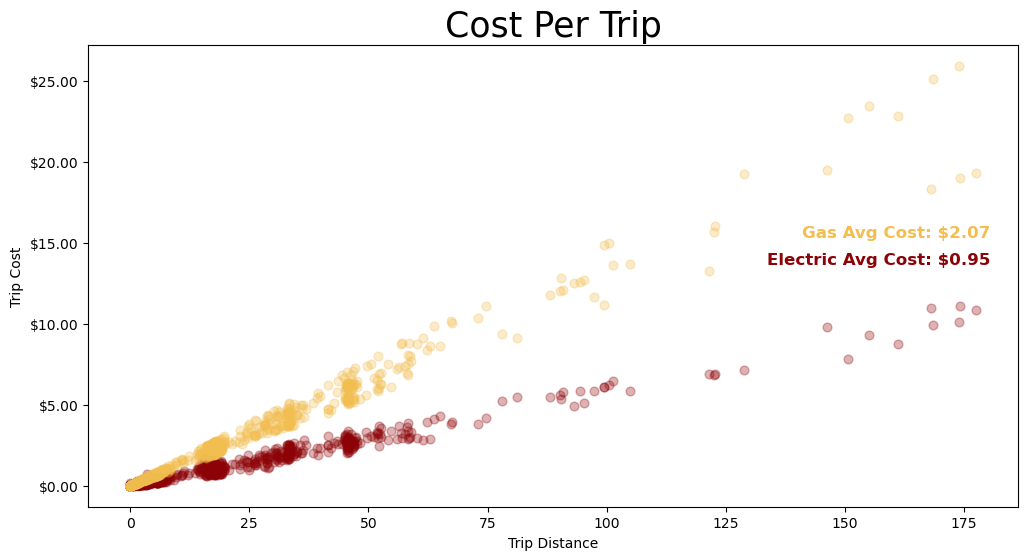

In [74]:
fig, ax = plt.subplots()

x = trips.distance
y1 = trips.trip_cost
y2 = trips.trip_cost_gas_car_eq

def dollar_format(x, pos):
    """The two arguments are the value and tick position."""
    return '${:1.2f}'.format(x)

plt.scatter(x,y1, color = '#8D0206', alpha = .3, s = 40)#red electric car
plt.scatter(x,y2, color = '#F2BE50', alpha = .3, s = 40)#champagne gas car




# labelling 

ax.text(x=0.97, y=0.55, transform=ax.transAxes, s = "Electric Avg Cost: $%1.2f" % y1.mean(),\
    fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='#8D0206')

ax.text(x=0.97, y=0.61, transform=ax.transAxes, s="Gas Avg Cost: $%1.2f" % y2.mean(),\
    fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
    backgroundcolor='white', color='#F2BE50')

plt.title('Cost Per Trip', fontsize = 25)
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Trip Cost') 
ax.yaxis.set_major_formatter(dollar_format);

In [89]:
trips.trip_cost_gas_car_eq.sum()-trips.trip_cost.sum()

1225.8744045350002